### MTA Subway Data Project (summer 2018)
Data preprocessing, analytics, and visualizations on MTA open source subway data

raw data source:
http://web.mta.info/developers/turnstile.html

In [0]:
import os
from datetime import datetime
from time import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('seaborn')

import seaborn as sns
import pandas as pd
import pickle
from IPython.core.display import display, HTML

import warnings
warnings.filterwarnings('ignore')
print('imports done')

imports done


### Data Preprocessing Functions 


1.651 min to complete


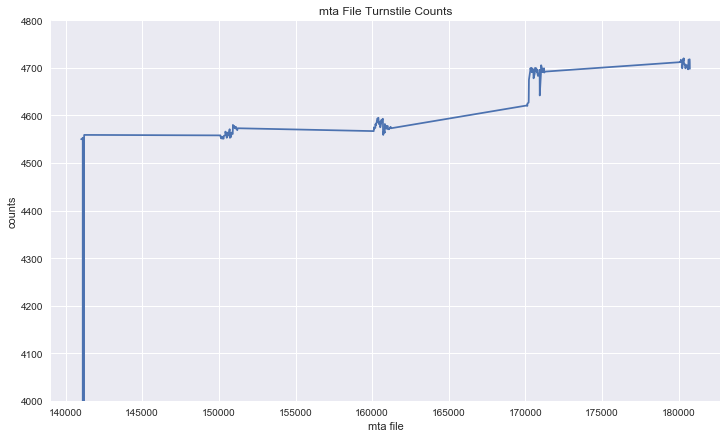

In [0]:
def add_stationlinename(inputdf):
    '''
    this function adds a new StationLinename feature in order to prevent duplicate STATION,LINENAME 
    by first sorting the LINENAME by char, numeric first then char, 
    then joins STATION+LINENAMES str
    inputdf   : a post-20141018 mta turnstile data set, DataFrame
    returns   : DataFrame
    '''
    df = inputdf.copy()
    # sort LINENAME feature data in order to consolidate occurences of both e.g. ACE123 and 123ACE into just one 123ACE
    df['LinenameSorted'] = df['LINENAME'].apply(lambda x: ''.join(sorted(list(x))))
    # add new feature
    df['StationLinename'] = df.STATION+'_'+df.LinenameSorted
    return df

def join_junction_stations(inputdf):
    '''
    consolidates stations known to be junctions, where transfers to other train lines are possible  
    '''
    junction_d = {'34 ST-PENN STA_123':'34 ST-PENN STA_123ACE','34 ST-PENN STA_ACE':'34 ST-PENN STA_123ACE',
                  '42 ST-PORT AUTH_1237ACEGNRS':'42 ST-PORT AUTH_TIMES SQ_1237ACEGNQRS','42 ST-PORT AUTH_1237ACENQRS':'42 ST-PORT AUTH_TIMES SQ_1237ACEGNQRS',
                  '42 ST-PA BUS TE_1237ACENQRS':'42 ST-PORT AUTH_TIMES SQ_1237ACEGNQRS','42 ST-PA BUS TE_1237ACEGNRS':'42 ST-PORT AUTH_TIMES SQ_1237ACEGNQRS',
                  'TIMES SQ-42 ST_1237ACENQRS':'42 ST-PORT AUTH_TIMES SQ_1237ACEGNQRS','42 ST-TIMES SQ_1237ACENQRS':'42 ST-PORT AUTH_TIMES SQ_1237ACEGNQRS', 
                  '14 ST_FLM123':'14 ST_123FLM','14TH STREET_1':'14 ST_123FLM',  
                  '4 AVE_DFGMNR':'4 AVE/9 ST_DFGMNR','9 ST_DFGMNR':'4 AVE/9 ST_DFGMNR',
                  'BROADWAY/LAFAY_6BDFQ':'BROADWAY-LAFAY/BLEECKER ST_6BDFM','BLEECKER ST_6DF':'BROADWAY-LAFAY/BLEECKER ST_6BDFM',
                  'CHAMBERS ST_123':'CHAMBERS ST_123456ACEJZ','CHAMBERS ST_23ACE':'CHAMBERS ST_123456ACEJZ','CHAMBERS ST_456JZ':'CHAMBERS ST_123456ACEJZ',
                  'JAY ST-METROTEC_ACF':'JAY ST-METROTEC_ACFR','JAY ST-METROTEC_R':'JAY ST-METROTEC_ACFR',
                  'COURT SQ_7':'COURT SQ_7EGM','COURT SQ_EGM':'COURT SQ_7EGM',
                  'NEWARK C_1':'NEWARK BM_BW_C_HE_HM_HW_1','NEWARK HM HE_1':'NEWARK BM_BW_C_HE_HM_1','NEWARK HW BMEBE_1':'NEWARK BM_BW_C_HE_HM_1',
                  'PATH WTC 2_1':'PATH WTC_1',
                  'PELHAM PKWY_5':'PELHAM PKWY_25',
                  'HOWARD BCH-JFK_A':'JFK HOWARD BEACH_A','HOWARD BEACH JFK_A':'JFK HOWARD BEACH_A'}
    df = inputdf.copy()
    # assumes StationLinename feature alread exists 
    if 'StationLinename' not in df.columns:
        print('adding "StationLinename feature"')
        df['StationLinename'] = df.STATION+'_'+df.LINENAME
    df['StationLinename'] = np.where(df.StationLinename.isin(junction_d),df.StationLinename.map(junction_d),df.StationLinename)
    return df

def old_new_transform(inputdf):
    '''
    inputdf is pre-2014 format mta data
    returns  : new mta format, DataFrame
    '''
    unitcols=['C/A','UNIT','SCP']
    caunit = inputdf.loc[:,unitcols]
    audit = inputdf.drop(caunit.columns,axis=1)
    # get audit_n for n in 1:8
    dflist = [pd.concat([caunit,inputdf['DATE'+str(i)],
                      inputdf['TIME'+str(i)],
                      inputdf['DESC'+str(i)],
                      inputdf['ENTRIES'+str(i)],
                      inputdf['EXITS'+str(i)] ],axis=1) 
              for i in range(1,9)]
    colname_common = unitcols+['DATE','TIME','DESC','ENTRIES','EXITS']
    # rename with common column names
    for i in range(len(dflist)):
        dflist[i].columns = colname_common
    # concatenate old format individual dfs into new format single df    
    new_format_df = pd.concat(dflist,axis=0)
    return new_format_df.sort_values(['C/A','UNIT','SCP']).reset_index(drop=True)
  
def mybarplot(inputdf,xfeature='',yfeature='',bars=20):
    '''
    function to return sns barplot on turstile volume results
    '''
    import matplotlib.ticker as ticker
    df=inputdf.copy()
    fig,ax= plt.subplots(figsize=(10,4))
#     sns.set(style="white", context="talk")
    ax = sns.barplot(x=df[xfeature].head(bars),y=df[yfeature].head(bars),palette="Reds_d")
    ax.set_xlabel('{}s'.format(xfeature))
    # set x ticks to 1 incr
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 1))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))   
    plt.show()

def distplot(inputdf,features=['ENTRIES'],binvalue=0,violin=1,describe=1):
    '''pick
    a function which computes a seaborn boxplot, useful to visualize IQR, median, outliers
    inputdf    : dataframe
    features   : features in the dataset, list of str
    binvalue   : number of bins in histogram, int
    violin     : violinplot toggle (1 for violin, 0 for distplot), binary
    describe   : indicator to print dataframe.describe() table, binary
    returns    : boxplot, seaborn object
    '''
    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.set_style('whitegrid')
    pd.options.display.float_format = '{:,.0f}'.format

    fig = plt.figure(figsize=(20,10))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    rows,cols=2,2
    for i,f in zip(range(1,3),features): # indices for subplot number
        # boxplots
        ax1 = fig.add_subplot(rows,cols,i)
        sns.boxplot(x=inputdf[f],ax=ax1,color='lightblue')
        ax1.set_title('{} Boxplot'.format(f))
        # plt.hist with sns.kde (kernel density) plots
        for i,f in zip(range(3,5),features): # indices for subplot number
            ax2 = fig.add_subplot(rows,cols,i)
            if binvalue>0:
                if violin:
                    sns.violinplot(inputdf[f].dropna(),ax=ax2,bins=binvalue,hist=True,kde=True)
                else:
                    sns.distplot(inputdf[f].dropna(),ax=ax2,bins=binvalue,hist=True,kde=True)
            else:
                if violin:
                    sns.violinplot(inputdf[f].dropna(),ax=ax2,hist=True,kde=True)
                else:
                    sns.distplot(inputdf[f].dropna(),ax=ax2,hist=True,kde=True)
            ax2.set_title('{} Histogram/distplot'.format(f))
    if describe:    
        print(inputdf[features].describe())

def station_merge(dfold,dfnew,key=['C/A','UNIT','SCP']):
    '''
    this function merges an old-formatted with a new-formatted df to join STATION and LINE to old-format data set 
    dfold     : pre-20141018 mta data, DataFrame
    dfnew     : post-20141018 mta data, DataFrame 
    returns   : dfold merged with dfnew 'STATION', 'LINENAME', 'DIVISION' columns, DataFrame  
    '''
    # get columns
    ca,unit,scp=key[0],key[1],key[2]
    leftdf,rightdf = dfold.copy(),dfnew.copy()
    # assign new common unique key "turnstile" 
    leftdf['turnstile'] = leftdf[ca]+' '+leftdf[unit]+' '+leftdf[scp]
    rightdf['turnstile'] =  rightdf[ca]+' '+rightdf[unit]+' '+rightdf[scp]
    # filter only necessary newdf columns
    rightdf = rightdf[['turnstile','STATION','LINENAME','DIVISION']]
    # merge on turnstile keys, inner only matches keys common to both data sets 
    mergedf = pd.merge(leftdf,rightdf.drop_duplicates(),on='turnstile',how='inner')
    return mergedf  

def generate_mta_filedates(start='111224',end='120519'):
    '''
    function which generates a tuples of dates,mta_file_dates in YYMMDD
    '''
    from datetime import datetime
    # append initial start
    datelist=[start]
    date=start
    def date_fwd(refdate='YYMMDD',ndays=7):
        '''
        function which computes the calendar date before or after refdate
        refdate     : YYMMDD format date, str
        days        : fwd calendar days to compute, int
        returns     : fwd calendar date in YYMMDD format, str 
        '''
        from datetime import datetime,timedelta
        # %y is year w/o century; %m is month 01 to 12; %d is day of month 01 to 31     
        fwd_datetime = datetime.strptime(refdate,'%y%m%d').date()
        return (fwd_datetime+timedelta(days=ndays)).strftime('%y%m%d')
    while date<end:
        date = date_fwd(date)
        datelist.append(date)
    return datelist    
 
def turnstile_sets(mtafilelist=[],filepath=os.getcwd()+'/mta_data/',usecols=['C/A','UNIT','SCP']):
    '''
    function which finds the mta files with largest turnstile sets to maximize turnstile joins when mapping STATION to old format files
    returns:    filename, str
    '''
    t0=time()
    # read data
    turnstile_counts = {}
    for fname in mtafilelist:
        dt = fname[10:16]
        if dt>='141018':
            try:
                df = pd.read_csv(filepath+fname,usecols=usecols)
            except: 
                print('delimeter issue')
                df = pd.read_csv(filepath+fname,sep=',')
            # assign turnstile attribute    
            df['turnstile'] = df['C/A']+' '+df['UNIT']+' '+df['SCP']
            turnstile_counts[dt] = len(set(df['turnstile']))
    # plot turnstile counts
    keys = sorted(list(turnstile_counts.keys()))
    counts = [turnstile_counts[k] for k in keys]
    fig,ax = plt.subplots(figsize=(12,7))
    ax.plot(keys,counts,label='turnstile count')
    ax.set(title='mta File Turnstile Counts',ylabel='counts',xlabel='mta file',
          ylim=((4000,4800)))
    t1 = time()-t0
    print('\n{:.3f} min to complete'.format(t1/60) )

flist = os.listdir(os.getcwd()+'/mta_extra_data/')
flist = sorted(flist)
turnstile_sets(flist,filepath=os.getcwd()+'/mta_extra_data/')


### Create and Pickle MTA Data Files
  - Consolidate individual DataFrames in dict to single DataFrame 
  - Pickle results 

In [0]:
def concat_new_mtafiles(datelist=[]):
    '''
    function which appends multiple new-format mta data sets to single set to obtain turnstile values
    datelist    : list of mta file dates, list of str
    returns     : DataFrame
    '''
    df = pd.concat([pd.read_csv(os.getcwd()+'/mta_data/turnstile_'+dt+'.txt') for dt in datelist])
    df['turnstile'] = df['C/A']+' '+df['UNIT']+' '+df['SCP']
    print('df rows={:,.0f}'.format(len(df)))
    return df.drop_duplicates(subset=['turnstile']).reset_index(drop=True)

def local_data_todict(newformat_df,mtafilelist=[],oldheaders=[],filepath=os.getcwd()+'/mta_data/'):
    '''
    reads local month-end mta, transforms ea set to new-format tables, and inserts df to dict
    newformat_df         : post-141018 mta dataset for mapping/joining STATION to pre-141018 mta data sets 
    mtafilelist          : file names returns by os., list of str
    oldheaders           : dataframe column headers for old format mta data, list of str
    filepath             : local os file path, str  
    returns              : dict of mta new format data DataFrames, dictionary
    '''
    # init dict which will contain mta weekly data file dfs
    dict_of_df = {}
    # read one new format data file to get STATION attribute for merging with older format files
#     newformat_df = pd.read_csv(filepath+'turnstile_141018.txt')
    i=0
    for fname in mtafilelist:
        # do processing for old mta data format
        dt = fname[10:16]
        t0=time()
        if dt<'141018':
            print('processing mta file date: {}'.format(dt))
            df = pd.read_csv(filepath+fname,names=oldheaders)
            # transform old to new format data
            df = old_new_transform(df)
            # convert leading zeros (read as str) to int (201204,20120714 files had mixed dtypes in EXITS, ENTRIES)
            df['EXITS'] = pd.to_numeric(df.EXITS,errors='coerce') 
            df['ENTRIES'] = pd.to_numeric(df.ENTRIES,errors='coerce') 
            # add by merge features STATION, LINENAME from post 20141018 data set
            df = station_merge(df,newformat_df,key=['C/A','UNIT','SCP'])
            # add stationlinename
            df = add_stationlinename(df)
            # join variants of STATION,LINENAME
            df = join_junction_stations(df)
            # insert df to dict
            dict_of_df[dt] = df.sort_values(['C/A','UNIT','SCP','DATE','TIME']).reset_index(drop=True)
            print('{} DataFrame created'.format(dt))
            t1 = time()-t0
            print('\n{:.3f} min to complete'.format(t1/60))
            i+=1
    print('\n*** dfs to dict done: {} files processed ***'.format(i))        
    return dict_of_df

# define pre_201410 column names
columnsold=['C/A','UNIT','SCP','DATE1','TIME1','DESC1','ENTRIES1','EXITS1',
           'DATE2','TIME2','DESC2','ENTRIES2','EXITS2',
           'DATE3','TIME3','DESC3','ENTRIES3','EXITS3',
           'DATE4','TIME4','DESC4','ENTRIES4','EXITS4',
           'DATE5','TIME5','DESC5','ENTRIES5','EXITS5',
           'DATE6','TIME6','DESC6','ENTRIES6','EXITS6',
           'DATE7','TIME7','DESC7','ENTRIES7','EXITS7',
           'DATE8','TIME8','DESC8','ENTRIES8','EXITS8']
    
def pickle_file(fileobj,filename='foo.pkl'):
    '''
    function which pickles a file to Google Cloud drive
    fileobj     : actual file obj to be pickled, obj
    filename    : name of file to pickle, str
    returns     : pickled file to Google Cloud Drive
    '''
    import pickle
    # specify output name and output as binary 
    output = open(filename,'wb')
    # assign file object to output as pickle obj
    pickle.dump(fileobj,output)
    print('{} pickle complete\n'.format(filename))
    # verify file was pickled to drive
    import os
    print('cwd file contents:\n{}'.format(os.listdir(".")))

# step 1: create dict of dfs
createdict=0
if createdict:
    flist = os.listdir(os.getcwd()+'/mta_data/')
    flist = sorted(flist)
    datelist = ['141018','141220','150509','150919','160402']
    newdfs = concat_new_mtafiles(datelist)
    dictdf12_13 = local_data_todict(newdfs,mtafilelist=flist,oldheaders=columnsold,filepath=os.getcwd()+'/mta_data/')  
    print('dict of dataframes created')

# step 2: pickle/read dict of dfs    
do_pickle_dictdf12_13=0
if do_pickle_dictdf12_13:
    pickle_file(dictdf12_13,filename='dictdf12_13.pkl')
    
read_dictdf12_13_pkl=0
if read_dictdf12_13_pkl:
    dictdf12_13 = pickle.load(open('dictdf12_13.pkl','rb'))
    print('pickle file read and assigned')

def dictdfs_to_df(inputdict):
    '''
    function which consolidates dfs in dict to a single df
    '''
    print('concatenating weekly data to single df:')
    t0 = time()
    # obtain mta file date keys
    keys = list(inputdict.keys())
    keys = sorted(keys)
    # create list of dfs
    dflist = [inputdict[k] for k in keys]
    # append dfs to single df
    df = pd.concat(dflist)
    df['DateTime'] = pd.to_datetime(df['DATE']+' '+df['TIME'],format=('%m-%d-%y %H:%M:%S'))
    t1 = time()-t0
    print('Time to build dataframe: {} mins'.format(t1/60))
    return df.reset_index(drop=True)

### STEP 3: compute single df of raw weekly mta files before cleaning and adding turnstile BUSYNESS
compute_dfraw=0
if compute_dfraw:
    df1213raw = dictdfs_to_df(dictdf12_13)
    pickle_file(df1213raw,filename='df1213raw.pkl')

read_df1213raw_pkl=0
if read_df1213raw_pkl:
    df1213raw = pickle.load(open('df1213raw_timestamp.pkl','rb'))
    print('pickle file read and assigned')


pickle file read and assigned


### Verify Turnstile Features are Distinct IDs
  - where turnstile feature is string: 'C/A UNIT SCP' 

In [0]:
def verify_unique_turnstiles(inputdf):
    '''
    function which asserts unique turnstile ids
    returns   : DataFrame
    '''
    # grp0 returns turnstiles with StationLinenames 
    grp0 = inputdf.groupby(['turnstile','StationLinename'],as_index=False).count()
    # grp1 splits on turnstile to collapse StationLinenames, returns number of StationLinenames per turnstile id 
    grp1 = grp0.groupby('turnstile',as_index=False)['StationLinename'].count()
    result = grp1[grp1.StationLinename>1]
    if len(result)>0:
        print('turnstile ids are not unique:')
        display(result)
    else:
        print('turnstile ids are unique')

verify_unique_turnstiles(df1213raw)

turnstile ids are unique


### Data Issue 1:
  - We expect ENTRIES,EXITS odometer values to be nonnegative, but this may not hold
  - Odometer values which are negative are increasing over time, so we can still compute changes between audits by taking absolute values of differences between rows 

,C/A,UNIT,SCP,DATE,TIME,DESC,ENTRIES,EXITS,turnstile,STATION,LINENAME,DIVISION,LinenameSorted,StationLinename,DateTime
4186701,N601,R319,00-03-00,05-01-12,00:00:00,REGULAR,2813900.0,-144304472.0,N601 R319 00-03-00,LEXINGTON AVE,F,IND,F,LEXINGTON AVE_F,2012-05-01 00:00:00
4186702,N601,R319,00-03-00,05-01-12,04:00:00,REGULAR,2813923.0,-144304464.0,N601 R319 00-03-00,LEXINGTON AVE,F,IND,F,LEXINGTON AVE_F,2012-05-01 04:00:00
4186703,N601,R319,00-03-00,05-01-12,04:00:00,RECOVR AUD,2813923.0,-144304464.0,N601 R319 00-03-00,LEXINGTON AVE,F,IND,F,LEXINGTON AVE_F,2012-05-01 04:00:00
4186704,N601,R319,00-03-00,05-01-12,08:00:00,REGULAR,2813941.0,-144304299.0,N601 R319 00-03-00,LEXINGTON AVE,F,IND,F,LEXINGTON AVE_F,2012-05-01 08:00:00
4186705,N601,R319,00-03-00,05-01-12,10:36:27,DOOR OPEN,2813986.0,-144304126.0,N601 R319 00-03-00,LEXINGTON AVE,F,IND,F,LEXINGTON AVE_F,2012-05-01 10:36:27


             EXITS
count   22,558,940
mean     2,844,676
std     24,170,166
min   -878,997,156
25%        207,153
50%      1,236,200
75%      3,593,031
max    979,712,983


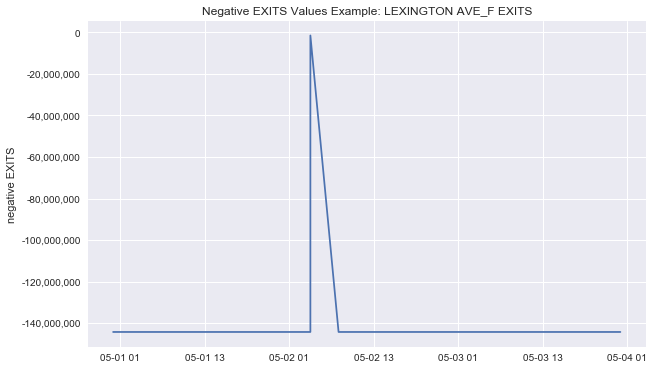

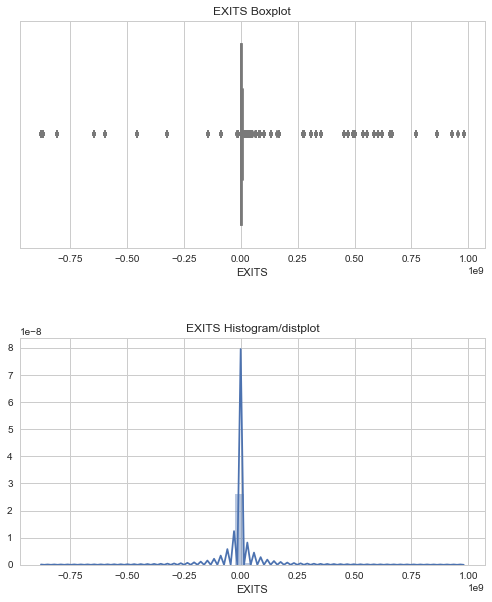

In [0]:
def return_neg_odometers(inputdf,sta='LEXINGTON',negfeature='EXITS',
                         start=pd.datetime(2012,5,15),end=pd.datetime(2012,6,1)):
    '''
    function which displays raw data negative odometer values 
    inputdf   : raw mta data set, DataFrame
    '''
    df = inputdf.copy()
    if sta is not None:
        df = df.loc[(df.StationLinename.str.contains(sta))
                    &(df.DateTime>=start)
                   &(df.DateTime<=end)]
    # get only negative odometer values
    df = df.loc[(df.ENTRIES<0)| (df.EXITS<0)]
    
    fig,ax = plt.subplots(figsize=(10,6))
    ax.plot(df.DateTime,df[negfeature])
    ax.set_ylabel('negative {}'.format(negfeature))
    station = df.StationLinename.iloc[0]
    ax.set_title('Negative EXITS Values Example: {} {}'.format(station,negfeature))
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    display(df.head())
    
return_neg_odometers(df1213raw,sta='LEXING',negfeature='EXITS',
                     start=pd.datetime(2012,5,1),end=pd.datetime(2012,5,4))
distplot(df1213raw,features=['EXITS'],describe=1,violin=0)

### Data Issue 2:
  - Turnstile odometer values may be reset after reaching a max value, causing negative audit changes 
  - This problem can be solved by dropping negative ENTRIES, EXITS changes 

,C/A,UNIT,SCP,DATE,TIME,DESC,ENTRIES,EXITS,turnstile,STATION,LINENAME,DIVISION,LinenameSorted,StationLinename,DateTime,date
23,A034,R170,03-00-02,01-02-12,13:13:53,OPEN,5211613.0,2694620.0,A034 R170 03-00-02,14 ST-UNION SQ,LNQR456,BMT,456LNQR,14 ST-UNION SQ_456LNQR,2012-01-02 13:13:53,2012-01-02
24,A034,R170,03-00-02,01-02-12,04:00:00,REGULAR,5211407.0,2694252.0,A034 R170 03-00-02,14 ST-UNION SQ,LNQR456,BMT,456LNQR,14 ST-UNION SQ_456LNQR,2012-01-02 04:00:00,2012-01-02
25,A034,R170,03-00-02,01-02-12,00:00:00,REGULAR,5211340.0,2694227.0,A034 R170 03-00-02,14 ST-UNION SQ,LNQR456,BMT,456LNQR,14 ST-UNION SQ_456LNQR,2012-01-02 00:00:00,2012-01-02
26,A034,R170,03-00-02,01-03-12,20:00:00,REGULAR,2904.0,1898.0,A034 R170 03-00-02,14 ST-UNION SQ,LNQR456,BMT,456LNQR,14 ST-UNION SQ_456LNQR,2012-01-03 20:00:00,2012-01-03
27,A034,R170,03-00-02,01-03-12,16:00:00,REGULAR,2052.0,1523.0,A034 R170 03-00-02,14 ST-UNION SQ,LNQR456,BMT,456LNQR,14 ST-UNION SQ_456LNQR,2012-01-03 16:00:00,2012-01-03
28,A034,R170,03-00-02,01-03-12,14:32:49,REGULAR,1805.0,1394.0,A034 R170 03-00-02,14 ST-UNION SQ,LNQR456,BMT,456LNQR,14 ST-UNION SQ_456LNQR,2012-01-03 14:32:49,2012-01-03


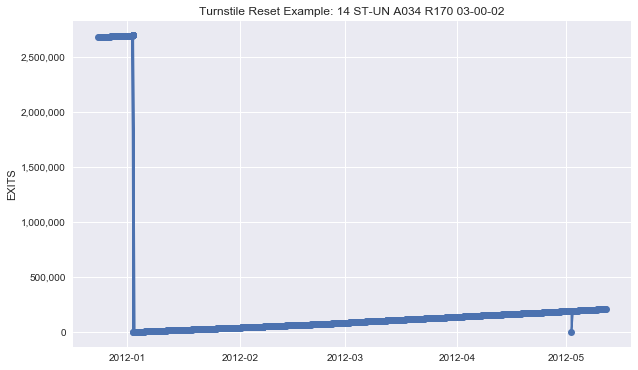

In [0]:
def return_odometer_resets(inputdf,filter=True,sta='',dt=pd.datetime(2011,12,26),turnstile='A034 R170 03-00-02'):
    '''
    function which returns odometer resets
    inputdf   : raw mta data set, DataFrame
    sta       : name of station to locate, str
    dt        : date to filter, datetime
    '''
    df = inputdf.copy().dropna(subset=['date'])
    if sta:
        df = df.loc[df.StationLinename.str.contains(sta)]  
        df.sort_values(['turnstile','date'],inplace=True)
    if turnstile:
        df = df.loc[df.turnstile==turnstile]
        df.sort_values(['date'],inplace=True)
    # viz resets
    plotdf = df.sort_values(['date'])
    fig,ax = plt.subplots(figsize=(10,6))
    ax.plot('DateTime','EXITS',data=plotdf,marker='o')
    ax.set_title('Turnstile Reset Example: {} {}'.format(sta,turnstile))
    ax.set_ylabel('EXITS')
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    if dt:        
        df = df.loc[df.DateTime==dt]
    if filter:
        df = df.loc[(df.groupby(['turnstile'])['ENTRIES'].apply(lambda x: x<x.shift(1)))
                   |(df.groupby(['turnstile'])['EXITS'].apply(lambda x: x<x.shift(1)))]
    return df.loc[(df.DateTime>pd.datetime(2011,12,31))
                 &(df.DateTime<pd.datetime(2012,1,4))].reset_index(drop=True)

data = df1213raw.loc[df1213raw.DateTime<pd.datetime(2012,5,12)]
data['date'] = pd.to_datetime(data['DATE'],format=('%m-%d-%y'))
return_odometer_resets(data,filter=False,sta='14 ST-UN',dt=None,turnstile='A034 R170 03-00-02').iloc[23:29]

### Data Issue 3:
  - There may be large discontinuous jumps between turnstile audit TIMEs, causing erroneous odometer changes 
  - We'll omit any rows with changes larger than a max value arg based on BUSYNESS upper quantiles

,C/A,UNIT,SCP,DATE,TIME,DESC,ENTRIES,EXITS,turnstile,STATION,LINENAME,DIVISION,LinenameSorted,StationLinename,DateTime,date
117640,PTH03,R552,00-00-00,12-24-11,00:53:50,REGULAR,9829.0,1151.0,PTH03 R552 00-00-00,JOURNAL SQUARE,1,PTH,1,JOURNAL SQUARE_1,2011-12-24 00:53:50,2011-12-24
117650,PTH03,R552,00-00-00,12-24-11,21:53:50,REGULAR,10291.0,1311.0,PTH03 R552 00-00-00,JOURNAL SQUARE,1,PTH,1,JOURNAL SQUARE_1,2011-12-24 21:53:50,2011-12-24
117649,PTH03,R552,00-00-00,12-24-11,20:35:47,REGULAR,501290.0,166472.0,PTH03 R552 00-00-00,JOURNAL SQUARE,1,PTH,1,JOURNAL SQUARE_1,2011-12-24 20:35:47,2011-12-24
117647,PTH03,R552,00-00-00,12-24-11,16:23:47,REGULAR,501248.0,166454.0,PTH03 R552 00-00-00,JOURNAL SQUARE,1,PTH,1,JOURNAL SQUARE_1,2011-12-24 16:23:47,2011-12-24
117646,PTH03,R552,00-00-00,12-24-11,13:29:50,REGULAR,10051.0,1207.0,PTH03 R552 00-00-00,JOURNAL SQUARE,1,PTH,1,JOURNAL SQUARE_1,2011-12-24 13:29:50,2011-12-24
117648,PTH03,R552,00-00-00,12-24-11,17:41:50,REGULAR,10201.0,1261.0,PTH03 R552 00-00-00,JOURNAL SQUARE,1,PTH,1,JOURNAL SQUARE_1,2011-12-24 17:41:50,2011-12-24


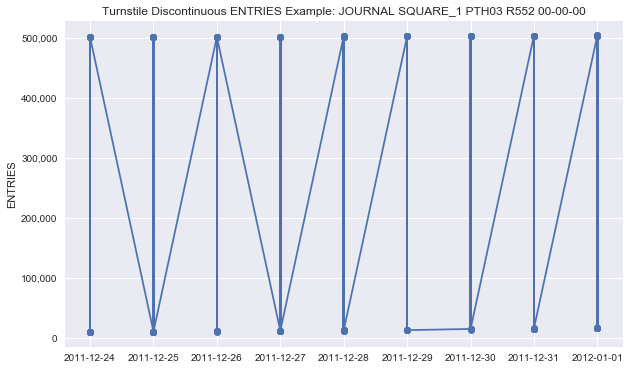

In [0]:
def return_odometer_jumps(inputdf,filter=True,auditchg=1000,sta=None,dt=pd.datetime(2012,1,1),turnstile='N405 R239 00-06-02',returndf=1):
    '''
    function which shows large odometer value changes relative to prev values
    inputdf    : raw mta data, DataFrame
    auditchg   : value of max ENTRIES change to filter/omit, int  
    filter     : arg which determines whether to apply ratio filter on turnstile changes, binary
    ratio      : max value of odometer pct chg, flt
    sta        : station to locate, str
    dt         : date to filter, datetime
    returndf   : return dataframe arg, binary 
    turnstile  : turnstile to filter, str
    '''
    df = inputdf.copy()
    df = df.loc[df.DESC=='REGULAR']
    if sta:
        df = df.loc[df.StationLinename.str.contains(sta)]
    if turnstile:
        df = df.loc[df.turnstile==turnstile]
    if dt:        
        df = df.loc[(pd.to_datetime(df.DateTime)<=dt)]
    # display resets
    df.sort_values(['date'],inplace=True)
    fig,ax = plt.subplots(figsize=(10,6))
    ax.plot('date','ENTRIES',data=df,marker='o')
    ax.set_title('Turnstile Discontinuous ENTRIES Example: {} {}'.format(df.StationLinename.iloc[0],turnstile))
    ax.set_ylabel('ENTRIES')
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    if filter:
        df.dropna(subset=['ENTRIES'],inplace=True)
        df = df.loc[(df.groupby(['turnstile'])['ENTRIES'].apply(lambda x: x.diff() >auditchg))]
    if returndf:
        display(df.sort_values(['turnstile','date']).head(6))

data = df1213raw[df1213raw.DateTime<pd.datetime(2012,1,3)]
data['date'] = pd.to_datetime(data['DATE'],format=('%m-%d-%y'))
return_odometer_jumps(data,filter=False,auditchg=2000,sta='JOURNAL',dt=pd.datetime(2012,1,2),turnstile='PTH03 R552 00-00-00',returndf=1) 

### Data Issue 4:
  - Turnstiles may be absent in some weekly mta data files, causing incorrect annual BUSYNESS growth/decline estimates
  - We'll omit rows where the ratio of 2013 over 2012 annual turnstile differences are greater than a max value arg 

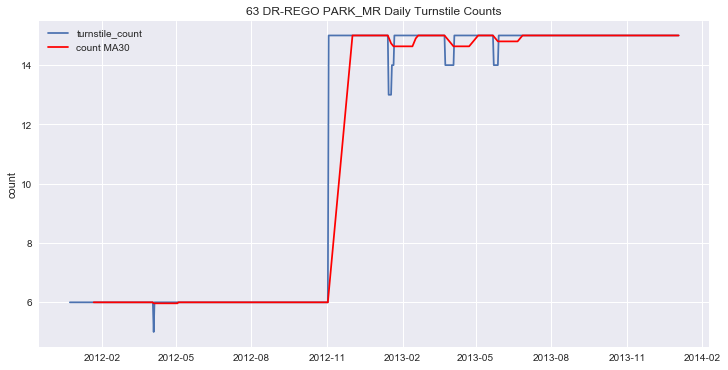

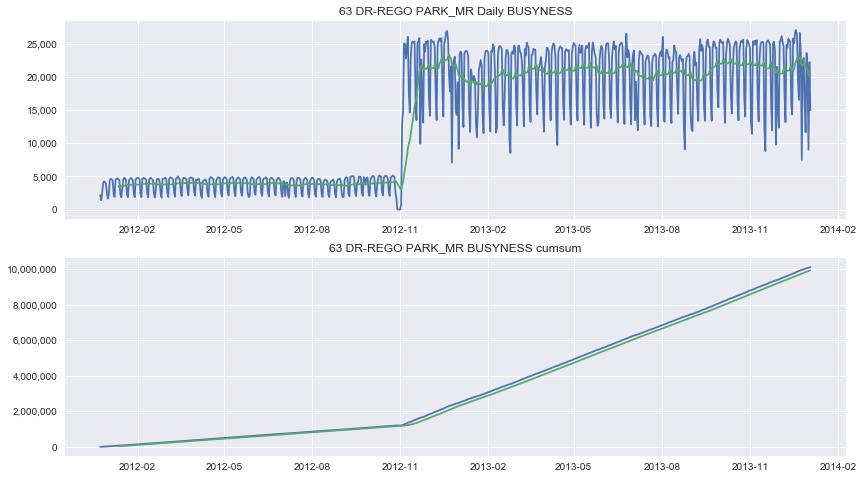

In [0]:
def station_turnstile_counts(inputdf,sta='',regular=0,ma=30,showdf=1):
    '''
    function which displays number of daily turnstiles at a StationLinename
    inputdf   : mta dataset over some daily time frame to display, DataFrame
    sta       : name to search in str.contains(), str
    regular   : arg which controls whether to omit non-REGULAR DESC, binary
    showdf    : arg which controls whether to display the dataframe, binary
    returns   : DataFrame if indicated
    '''
    df = inputdf.copy()
    df = df.loc[df.StationLinename.str.contains(sta)]
    if regular:
        df = df.loc[df.DESC=='REGULAR']
    # split on Date and Station
    df['date'] = pd.to_datetime(df['DATE'],format=('%m-%d-%y'))
    grp = df.groupby(['date','StationLinename','turnstile'],as_index=False)
    # collapse daily TIME rows for ea. turnstile: returns ea turnstiles by day 
    tmp = grp.aggregate({'ENTRIES':'count'})
    # split on StationLinename, turnstile to collapse DateTime to get daily turnstile agg 
    daily_grp = tmp.groupby(['date','StationLinename'],as_index=False)
    result = daily_grp.aggregate({'turnstile':'count'})
    # assign new moving average attribute
    mov=str(ma)
    result['COUNT_MA'+mov] = result['turnstile'].rolling(ma).mean()
    # plot daily turnstiles 
#     result['date'] = pd.to_datetime(result['DATE'],format=('%m-%d-%y'))
    station = result['StationLinename'].iloc[0]
    fig,ax = plt.subplots(figsize=[12,6])
    ax.plot(result['date'],result['turnstile'],label='turnstile_count')
    ax.plot(result['date'],result['COUNT_MA'+mov],color='red',label='count MA{}'.format(ma))
    ax.set_title('{} Daily Turnstile Counts'.format(station))
    ax.set_ylabel('count')
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    plt.legend()
    if showdf:
        display(result.head())
        
def view_station_activity(inputdf,ma=20,regular=0,station='',showdf=1):
    '''
    function which plots turnstile cumulative pct chg to verify annual PctChg
    inputdf    : annual mta data, DataFrame
    ma         : moving average arg, int
    regular    : arg to include only REGULAR DESC, binary 
    station    : station chars to search for in df[feature].str.contains() method, str
    returns    : plot of StationLinename BUSYNESS cumulative change
    '''
    df = inputdf.copy().sort_values(['turnstile','DateTime'])
    if regular:
        df = df.loc[df['DESC']=='REGULAR']
    df = df.loc[df['StationLinename'].str.contains(station)]
    df['date'] = pd.to_datetime(df['DATE'],format=('%m-%d-%y'))
    df['ENTRIES_chg'] = df.groupby(['turnstile'])['ENTRIES'].apply(lambda x: x.diff())
    df['EXITS_chg'] = df.groupby(['turnstile'])['EXITS'].apply(lambda x: x.diff())
    df['BUSYNESS'] = df.ENTRIES_chg+df.EXITS_chg 
    df = df[(df.BUSYNESS>=0)&(df.BUSYNESS<5000)]
    grp = df.groupby(['date','StationLinename'],as_index=False)
    # compute daily ser of BUSYNESS by StationLinename 
    result = grp.aggregate({'BUSYNESS':'sum'})
    # filter by station arg, collapses BUSYNESS by TIME
    # add moving average attribute
    busyness_ma_name = 'BUSYNESS_MA'+str(ma)
    result[busyness_ma_name] = result['BUSYNESS'].rolling(window=ma).mean()
    result['pct_chg'] = result.BUSYNESS.pct_change(periods=1)
    # add WeekDay attribute
    result['WeekDay'] = result['date'].map(lambda x: x.strftime('%a') )
    # add cumulative sum attribute
    result['cumsum'] = result['BUSYNESS'].cumsum()    
    # add cumsum moving average attribute
    cumsum_ma_name = 'cumsum_MA'+str(ma)
    result[cumsum_ma_name] = result['cumsum'].rolling(ma).mean()
    sta_name = result.StationLinename.ix[0]
    pd.options.display.float_format = '{:,.0f}'.format
    fig,ax = plt.subplots(2,figsize=(14,8))
    ax[0].plot(result['date'].dt.date,result['BUSYNESS'])
    ax[0].plot('date',busyness_ma_name,data=result)
    ax[0].set(title='{} Daily BUSYNESS'.format(sta_name) )
    ax[0].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    ax[1].plot('date','cumsum',data=result)
    ax[1].plot('date',cumsum_ma_name,data=result)
    ax[1].set(title='{} BUSYNESS cumsum'.format(sta_name))
    ax[1].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    if showdf:
        return result.sort_values('date')

def view_turnstile_activity(inputdf,ma=20,regular=0,station='',turnstile_id='',showdf=1):
    '''
    function which plots a particular turnstile cumulative chg to verify turnstile data is continuous through year 
    inputdf    : annual mta data, DataFrame
    ma         : moving average arg, int
    regular    : arg to include only REGULAR DESC, binary 
    station    : station chars to search for in df[feature].str.contains() method, str
    returns    : plot of StationLinename BUSYNESS cumulative change
    '''
    df = inputdf.copy()
    if regular:
        df = df.loc[df['DESC']=='REGULAR'].loc[df.turnstile==turnstile_id]
    df = df.loc[df['StationLinename'].str.contains(station)]
    df['date'] = pd.to_datetime(df['DATE'],format=('%m-%d-%y'))
    grp = df.groupby(['StationLinename'],as_index=False)
    # compute daily ser of BUSYNESS and turnstile counts by StationLinename 
    result = grp.aggregate({'turnstile':'last','turnstile':'count','BUSYNESS':'sum'})
    display(result)
    # add moving average attribute
    busyness_ma_name = 'BUSYNESS_MA'+str(ma)
    result[busyness_ma_name] = result['BUSYNESS'].rolling(window=ma).mean()
    result['pct_chg'] = result.BUSYNESS.pct_change(periods=1)
    # add WeekDay attribute
    result['WeekDay'] = result['date'].map(lambda x: x.strftime('%a') )
    # add cumulative sum attribute
    result['cumsum'] = result['BUSYNESS'].cumsum()    
    # add cumsum moving average attribute
    cumsum_ma_name = 'cumsum_MA'+str(ma)
    result[cumsum_ma_name] = result['cumsum'].rolling(ma).mean()
    sta_name = result.StationLinename.ix[0]
    pd.options.display.float_format = '{:,.0f}'.format
    fig,ax = plt.subplots(2,figsize=(14,8))
    ax[0].plot('date','BUSYNESS',data=result)
    ax[0].plot('date',busyness_ma_name,data=result)
    ax[0].set_title('{} Daily BUSYNESS'.format(sta_name))
    ax[0].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    ax[1].plot('date','cumsum',data=result)
    ax[1].plot('date',cumsum_ma_name,data=result)
    ax[1].set_title('{} BUSYNESS cumsum'.format(sta_name))
    ax[1].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    if showdf:
        return result.sort_values('date')
try:
    df1213raw
except:
    NameError
    df1213raw = pickle.load(open('df1213raw.pkl','rb'))
    print('pickle file read and assigned')

# display REGO PARK having large change in turnstile counts in Nov 2012 data file      
sta='REGO'    
station_turnstile_counts(df1213raw,sta=sta,regular=1,ma=30,showdf=0)    
view_station_activity(df1213raw,ma=20,regular=0,station=sta,showdf=0)


### Data Cleaning, Add BUSYNESS Attribute     
  - Clean data:
    - Problem 1: Odometers may reset to 0 after some max value
    - Problem 2: Next odometer value may jump far from current value 
    - Problem 3: ENTRIES,EXITS may be negative
  - add turnstile ENTRIES_chg, EXITS_chg, BUSYNESS attributes
  - consolidate data in dict to single DataFrame

pickle load done
raw data:


,ENTRIES_chg,EXITS_chg
count,"22,561,688","22,547,182"
mean,609,294
std,"806,559","845,889"
min,"-931,476,882","-979,712,983"
25%,2,2
50%,53,39
75%,210,147
max,"916,848,568","971,924,691"


abs of negative odometers:


,ENTRIES_chg,EXITS_chg
count,"22,561,688","22,547,182"
mean,609,294
std,"806,559","845,889"
min,"-931,476,882","-979,712,983"
25%,2,2
50%,53,39
75%,210,147
max,"916,848,568","971,924,691"


BUSYNESS quantile(0.98)=	1,460
BUSYNESS quantile(0.99)=	1,765
BUSYNESS quantile(0.995)=	2,055
BUSYNESS quantile(0.9975)=	2,341
BUSYNESS quantile(0.999)=	2,724

omit negative odometer changes:


,ENTRIES_chg,EXITS_chg
count,"22,541,426","22,541,426"
mean,822,773
std,"480,754","566,473"
min,0,0
25%,2,2
50%,54,39
75%,210,147
max,"835,617,660","971,924,691"


1,849,942 (0.076) rows omitted where (ENTRIES_chg<=0 & EXITS_chg<=0)

Cleaning results: 1,849,942 (0.076) total rows omitted

clean/add changes runtime: 1.10 mins
df1213clean.pkl pickle complete


df1213clean dataframe created
raw data:


,ENTRIES_chg,EXITS_chg
count,"10,856,372","10,841,866"
mean,327,-83
std,"526,032","608,638"
min,"-453,970,098","-888,458,091"
25%,3,3
50%,55,40
75%,212,151
max,"902,455,965","926,285,809"


abs of negative odometers:


,ENTRIES_chg,EXITS_chg
count,"10,856,372","10,841,866"
mean,327,-83
std,"526,032","608,638"
min,"-453,970,098","-888,458,091"
25%,3,3
50%,55,40
75%,212,151
max,"902,455,965","926,285,809"


BUSYNESS quantile(0.98)=	1,464
BUSYNESS quantile(0.99)=	1,772
BUSYNESS quantile(0.995)=	2,063
BUSYNESS quantile(0.9975)=	2,350
BUSYNESS quantile(0.999)=	2,756

omit negative odometer changes:


,ENTRIES_chg,EXITS_chg
count,"10,838,509","10,838,509"
mean,402,529
std,"241,416","371,730"
min,0,0
25%,3,3
50%,56,40
75%,212,151
max,"601,590,135","926,285,809"


22,287 (0.002) rows omitted where (ENTRIES_chg<=0 & EXITS_chg<=0)

Cleaning results: 22,287 (0.002) total rows omitted

clean/add changes runtime: 0.61 mins
df12clean.pkl pickle complete


df12clean dataframe created/pickled
raw data:


,ENTRIES_chg,EXITS_chg
count,"11,444,201","11,444,201"
mean,806,602
std,"978,616","1,012,582"
min,"-931,476,882","-979,712,983"
25%,2,1
50%,52,37
75%,209,145
max,"916,848,568","971,924,691"


abs of negative odometers:


,ENTRIES_chg,EXITS_chg
count,"11,444,201","11,444,201"
mean,806,602
std,"978,616","1,012,582"
min,"-931,476,882","-979,712,983"
25%,2,1
50%,52,37
75%,209,145
max,"916,848,568","971,924,691"


BUSYNESS quantile(0.98)=	1,460
BUSYNESS quantile(0.99)=	1,763
BUSYNESS quantile(0.995)=	2,051
BUSYNESS quantile(0.9975)=	2,335
BUSYNESS quantile(0.999)=	2,698

omit negative odometer changes:


,ENTRIES_chg,EXITS_chg
count,"11,441,911","11,441,911"
mean,"1,148",963
std,"581,245","683,992"
min,0,0
25%,2,2
50%,52,37
75%,209,145
max,"771,438,080","971,924,691"


6,795 (0.001) rows omitted where (ENTRIES_chg<=0 & EXITS_chg<=0)

Cleaning results: 6,795 (0.001) total rows omitted

clean/add changes runtime: 0.55 mins
df13clean.pkl pickle complete


df13clean dataframe created


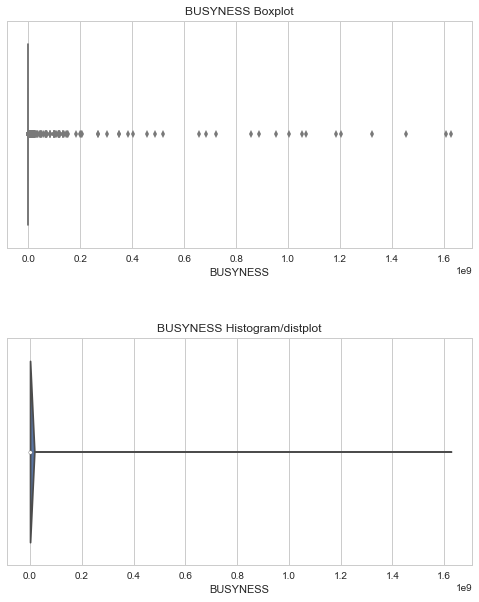

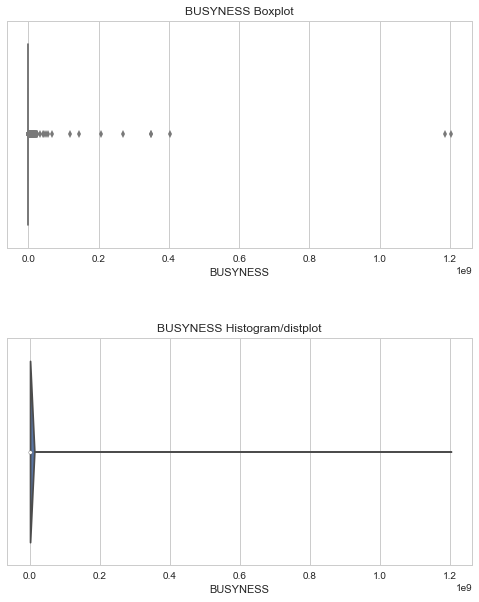

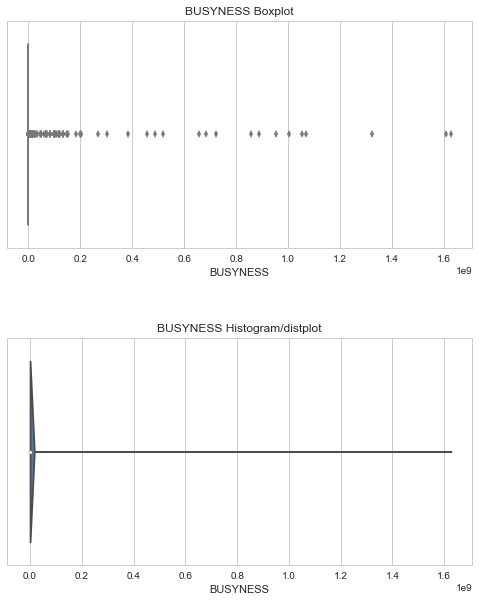

In [0]:
def clean_add_changes(inputdf,busymax=2000):
    '''
    function which addresses mta data problems and adds odometer change/BUSYNESS attributes
    inputdf   : mta raw dataset, DataFrame
    '''
    t0 = time()
    df = inputdf.copy()
    N = len(df)
    n = N
    # split on date and turnstile
    df.sort_values(['DateTime','turnstile'],inplace=True)
    grp = df.groupby('turnstile')
    # add odometer changes
    df['ENTRIES_chg'] = grp['ENTRIES'].apply(lambda x: x-x.shift(1))
    df['EXITS_chg'] = grp['EXITS'].apply(lambda x: x-x.shift(1))
    des0 = df[['ENTRIES_chg','EXITS_chg']].describe()
    print('raw data:')
    display(des0)
    # data problem 1: negative odometer values will cause negative change values  
    df['ENTRIES_chg'] = np.where((df['ENTRIES']<0)&(df['ENTRIES'].shift(1)<df['ENTRIES']),
                                np.abs(df['ENTRIES_chg']),df['ENTRIES_chg'])         
    df['EXITS_chg'] = np.where((df['EXITS']<0)&(df['EXITS'].shift(1)<df['EXITS']),
                                np.abs(df['EXITS_chg']),df['EXITS_chg'])         
    df['BUSYNESS'] = df['ENTRIES_chg']+df['EXITS_chg']
    
    des1=df[['ENTRIES_chg','EXITS_chg']].describe()
    print('abs of negative odometers:')
    display(des1)
    # large upper percentiles as reference
    percents = [.98,.99,.995,.9975,.999]
    for p in percents:
        print('BUSYNESS quantile({})=\t{:,.0f}'.format(p,df.BUSYNESS.quantile(p)))
    # data problem 2: odometer resets will cause negative odometer changes
    df = df.loc[(df['ENTRIES_chg']>=0)
               &(df['EXITS_chg']>=0)]
    des2 = df[['ENTRIES_chg','EXITS_chg']].describe()
    print('\nomit negative odometer changes:')
    display(des2)
    diff = n-len(df) 
    pct = diff/n
    n=len(df)
    print('{:,.0f} ({:.3f}) rows omitted where (ENTRIES_chg<=0 & EXITS_chg<=0)'.format(diff,pct))
    # data problem 3: omit odometer jumps causing large positive change values
    if busymax:
        df = df.loc[(df['BUSYNESS']<=busymax)]
        des3 = df[['ENTRIES_chg','EXITS_chg']].describe()
        print('\nbusymax applied:')
        display(des3)
        diff = n-len(df) 
        pct = diff/n
        n=len(df)
        print('{:,.0f} ({:.3f}) rows omitted where (BUSYNESS>buysmax) '.format(diff,pct))
    t1= time()
    m = (t1-t0)/60
    print('\nCleaning results: {:,.0f} ({:.3f}) total rows omitted'.format(diff,pct))
    distplot(df,features=['BUSYNESS'],describe=0)
    diff = N-len(df)
    pct = diff/N
    print('\nclean/add changes runtime: {:,.2f} mins'.format(m) )
    return df

pd.options.display.float_format = '{:,.0f}'.format

# clean,add chg dfs
read_df1213raw_pkl=1
if read_df1213raw_pkl:
    df1213raw = pickle.load(open('df1213raw.pkl','rb'))
#     df1213raw['date'] = pd.to_datetime(df1213raw['DATE'],format=('%m-%d-%y'))
    print('pickle load done')

### CLEAN df1213raw & PICKLE DATA ###    
create_df1213clean=0
if create_df1213clean:
    df1213clean = clean_add_changes(df1213raw,busymax=None)
    pickle_file(df1213clean,filename='df1213clean.pkl')
    print('\ndf1213clean dataframe created')

create_df12clean=0
if create_df12clean:
    data = df1213raw.loc[(df1213raw.DateTime>=pd.datetime(2011,12,31))
                        &(df1213raw.DateTime<pd.datetime(2013,1,1))]
    df12clean = clean_add_changes(data,busymax=None)
    df12clean['date'] = pd.to_datetime(df12clean['DATE'],format=('%m-%d-%y'))
    pickle_file(df12clean,filename='df12clean.pkl')
    print('\ndf12clean dataframe created/pickled')
    
create_df13clean=0
if create_df13clean:
    data = df1213raw.loc[(df1213raw.DateTime>=pd.datetime(2012,12,31))
                        &(df1213raw.DateTime<pd.datetime(2014,1,1))]
    df13clean = clean_add_changes(data,busymax=None)
    df13clean['date'] = pd.to_datetime(df13clean['DATE'],format=('%m-%d-%y'))
    pickle_file(df13clean,filename='df13clean.pkl')
    print('\ndf13clean dataframe created')    


### Analyze Cleaned Data 
  - Analyze remaining outliers following intial cleaning
  - pivot_table reveals: 
    - DESC tagged with 064, DOOR CLOSE, LOGON, DOOR OPEN,... (i.e. turnstile adjustments) are bulk of BUSYNESS outliers  
  - My remedy for outliers will be to omit any BUSYNESS > 1500   


mean BUSYNESS by DESC:


,BUSYNESS
DESC,
064,"83,866,386"
DOOR CLOSE,"42,330"
LOGON,"17,479"
DOOR OPEN,"9,891"
TS VLT OPN,"2,398"
LGF-MAN,"2,000"
TS,"1,034"
RECOVR AUD,979
RECOVR,759



mean BUSYNESS by DESC binned by BUSYNESS


BUSYNESS,"(0.0, 500.0]","(500.0, 1500.0]","(1500.0, 50000.0]","(50000.0, inf]"
DESC,,,,
064,nan,nan,nan,"83,866,386"
AUD,169,698,"2,662","4,189,702"
BRD,187,796,nan,nan
CHG,107,956,nan,nan
DOOR,99,796,"2,278","4,388,421"
DOOR CLOSE,16,789,"2,349","234,204,740"
DOOR OPEN,87,783,"2,191","27,423,522"
LGF-MAN,6,918,"5,963","20,834,076"
LOGON,34,798,"4,453","40,138,483"



mean BUSYNESS by DESC and DIVISION


DIVISION,BMT,IND,IRT,PTH,RIT,SRT
DESC,,,,,,
064,nan,nan,"83,866,386",nan,nan,nan
AUD,"1,307",190,230,141,34,96
B5B6B7B8B9,nan,nan,0,nan,nan,nan
BRD,28,0,64,nan,nan,0
CHG,99,0,128,nan,nan,103
DOOR,246,612,"1,468",443,44,37
DOOR CLOSE,"72,567","34,990","38,391","5,343,234",3,2
DOOR OPEN,"15,315","9,471","9,638",758,32,969
LGF-MAN,"2,879","2,985",459,2,1,0


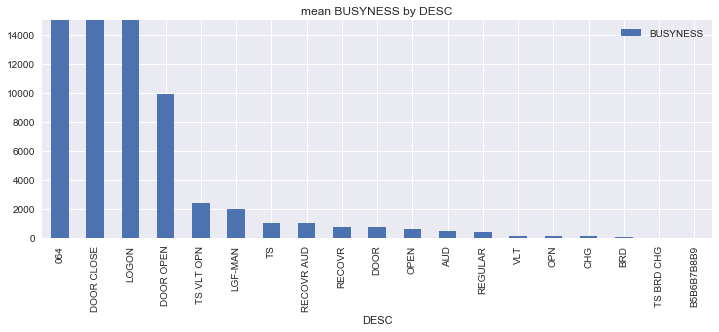

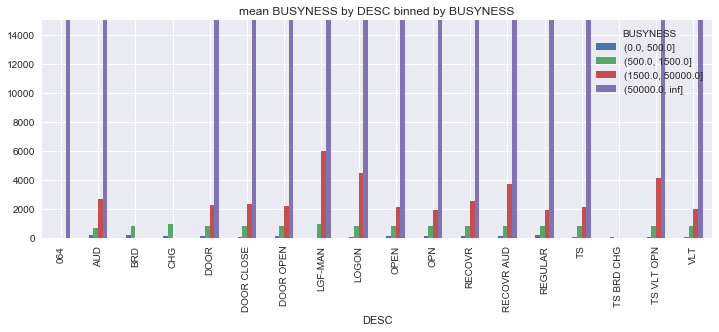

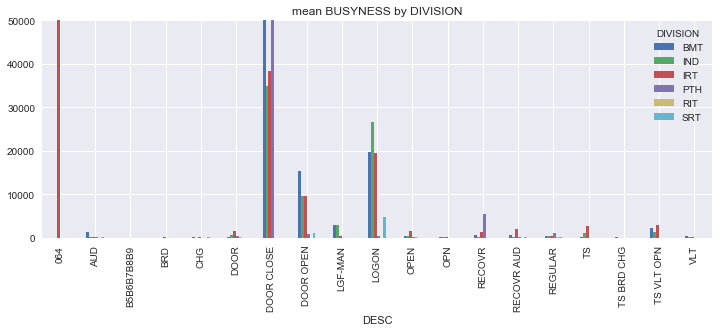

In [0]:
try:
    df1213clean
except:
    NameError
    df1213clean =  pickle.load(open('df1213clean.pkl','rb'))
    print('pickle file loaded\n')
    
def analyze_cleaned(inputdf,idx='DESC',feature='BUSYNESS',cutname='BUSYNESS',ag='mean',ymax=20000):
    '''
    function which reviews remaining outliers in cleaned data
    '''
    df = inputdf.copy()
    # by DESC
    by_desc = df.pivot_table(feature,index=idx,aggfunc=ag).sort_values(feature,ascending=False)  
    by_desc.plot(figsize=(12,4),kind='bar',ylim=(0,ymax),title='{} {} by {}'.format(ag,feature,idx))
    print('\n{} {} by {}:'.format(ag,feature,idx))
    display(by_desc)
    # bin the persec
    busybin = pd.cut(df[cutname],[0,500,1500,50000,np.Infinity])
    bybusybin = df.pivot_table(feature,index=idx,columns=busybin,aggfunc={'BUSYNESS':ag})
#     bybusybin.sort_values(feature,ascending=False,inplace=True)
    print('\n{} {} by {} binned by {}'.format(ag,feature,idx,feature))
    display(bybusybin)
    bybusybin.plot(figsize=(12,4),kind='bar',ylim=(0,ymax),title='{} {} by {} binned by {}'.format(ag,feature,idx,feature))
    # by DIVISION
    bydiv = df.pivot_table(feature,index=idx,columns='DIVISION',aggfunc=ag)
    print('\n{} {} by {} and DIVISION'.format(ag,feature,idx))
    display(bydiv)
    bydiv.plot(figsize=(12,4),kind='bar',ylim=(0,50000),title='{} {} by {}'.format(ag,feature,'DIVISION'))
    pd.options.display.float_format = '{:,.0f}'.format

try: 
    pvtdata 
except:
    NameError
    pvtdata = df1213clean.sort_values('BUSYNESS',ascending=False)    
analyze_cleaned(pvtdata,idx='DESC',feature='BUSYNESS',ag='mean',ymax=15000)

### Data Analysis Questions
  1. Which Station had the most number of units?
  2. What is the total number of ENTRIES and EXITS across the subway system for 8/1/2013? 
  3. Define BUSYNESS as the sum of ENTRIES and EXITS count. What station was busiest on 8/1/2013? 
  4. What stations have seen the most usage growth/decline?
  5. What dates are the least busy? Can you identify days which stations were not operating at full capacity or were closed entirely?

In [0]:
def compute_busyness(inputdf,spliton=['date'],datefilter=pd.datetime(2013,8,1)):
    '''
    function which splits data by spliton in groupby to aggregate BUSYNESS feature, filtered by DateTime or not
    inputdf    : consolidated annual mta data with DateTime,StationLiname,turnstile,ENTRIES,EXITS attributes, DataFrame
    spliton    : attribute(s) to split on in groupby, list of str
    datefilter : indicator controls whether to filter by dateTime, datetime 
    returns    : transformed DataFrame
    '''
    df = inputdf.copy()
    pd.options.display.float_format = '{:,.0f}'.format
    if datefilter is not None:  # this solves data analysis problem 2
        # assign datetime parts to filter by date
#         yyyy,mm,dd = datefilter[0],datefilter[1],datefilter[2]
        df = df.loc[df['date']==datefilter]
        resultdf = df.groupby(spliton,as_index=False)['BUSYNESS'].sum().sort_values('BUSYNESS',ascending=False)
        pd.options.display.float_format = '{:,.0f}'.format
        # add datetime.WeekDay attribute
        df['WeekDay'] = df['date'].map(lambda x: x.strftime('%a'))
        return resultdf
    else: # this solve data analysis problem 5a: what dates are least busy?
        resultdf = df.groupby(spliton,as_index=False).aggregate({'ENTRIES_chg':'sum','EXITS_chg':'sum','BUSYNESS':'sum'}).sort_values('BUSYNESS',ascending=False)
        # add datetime.WeekDay attribute
        resultdf['WeekDay'] = resultdf['date'].map(lambda x: x.strftime('%a'))
        return resultdf

def problem1(inputdf,date=pd.datetime(2013,8,1),maxrows=4):
    '''
    '''
    df = inputdf.copy()
    # filter Date
    df = df.loc[df['date']==date]
    # spliton by StationLinename and agg to get a DataFrame wtih StationLinename and UNITs
    grp = df.groupby(['StationLinename','UNIT'],as_index=False).count()
    # spit on StationLinename again to collapse UNIT attribute
    grp2 = grp.groupby('StationLinename',as_index=False)
    # apply agg on UNIT
    result = grp2['UNIT'].count().sort_values('UNIT',ascending=False).reset_index(drop=True)
    # display top maxrows STATIONs by UNIT
    mybarplot(result,xfeature='UNIT',yfeature='StationLinename',bars=maxrows)
    print('The STATIONs with the most UNITs on {} were:'.format(date))
    display(result.head(maxrows))
    
def problem2(inputdf):
    '''
    inputdf    : mta data which includes 20130801, DataFrame
    spliton_   : atributes to split data in groupby, list of str
    datefilter : filters data by DateTime args, list of int
    returns    : answers to the following questions...
    
    What is the total number of entries & exits across the subway system for August 1, 2013?
    '''
    line_len=72
    print('_'*line_len)
    print('\nComputing data analysis problem 2:')
    print('What is the total number of entries & exits across the subway system for August 1, 2013?')
    
    result = compute_busyness(inputdf,spliton=['date'],datefilter=pd.datetime(2013,8,1))
    print('\nEstimated Total Entries & EXITS across the subway system on 20130801:')
    display(result)

def problem3(inputdf,iloc_size=2):
    '''
    inputdf    : mta data which includes 20130801, DataFrame
    spliton_   : atributes to split data in groupby, list of str
    datefilter : filters data by DateTime args, list of int
    iloc_size  : upper limit of .iloc slice in final results, int
    returns    : answers to the following questions...
    
    Let’s define the busy-ness as sum of entry & exit count. 
    (a) What station was the busiest on August 1, 2013? 
    (b) What turnstile was the busiest on that date?
    '''
    
    line_len=72
    print('_'*line_len)
    print('\nComputing data analysis problem 3a:\nWhat station was the busiest on August 1, 2013?\n')
    result_a = compute_busyness(inputdf,spliton=['StationLinename'],datefilter=pd.datetime(2013,8,1)).reset_index(drop=True)
    print('Estimated Busiest Station on 20130801:')
    display(result_a.iloc[0:iloc_size])
    print('-'*line_len)
    print('\nComputing data analysis problem 3b:\nWhat turnstile was the busiest on that date?\n')
    result_b = compute_busyness(inputdf,spliton=['StationLinename','turnstile'],datefilter=pd.datetime(2013,8,1)).reset_index(drop=True)
    display(result_b.iloc[0:iloc_size])    


def problem4(inputdf12,inputdf13,regular=0,ratiolow=.3,ratiolimit=5,method='mean',ma=7,diffmax=2000000,return_ma=True,rows=10):
    '''
    function which returns solution for data analysis question 4
    inputdf_    : outlier cleaned mta data (must separate years else MemoryError), DataFrame
    regular     : arg to omit DESC != REGULAR, binary
    ratiolow    : mergedf turnstile BUSYNESS_y/BUSYNESS_x ratio by turnstile low filter, flt
    ratiolimit  : mergedf turnstile BUSYNESS_y/BUSYNESS_x ratio by turnstile max filter, flt 
    method      : aggregation method, str
    ma          : moving average value for rolling mean, int
    diffmax     : arg value to omit StationLinename annual diff > diffmax, int 
    return_ma   : arg which determines whether to return annual pct chg based on moving average, bool 
    rows        : arg to control number of rows to display in upper/lower pct chg  
    describe    : indicator to display describe() method, binary
    '''
    pd.options.display.float_format = '{:,.3f}'.format
    line_len=72
    print('_'*line_len)
    print('\nComputing data analysis problem 4:\nWhat stations have seen the most usage growth/decline in 2013?')
    df12,df13 = inputdf12.copy(),inputdf13.copy() 
    if regular:
        df12,df13 = df12.loc[df12.DESC=='REGULAR'],df13.loc[df13.DESC=='REGULAR']
    # include only BMT,IND,IRT DIVISIONS  
    mta_divisions = ['BMT','IND','IRT']
    df12,df13 = df12.loc[df12.DIVISION.isin(mta_divisions)],df13.loc[df13.DIVISION.isin(mta_divisions)]
    # initial data is BUSYNESS by date,StationLinename,turnstile
    # include turnstile in group because same turnstiles may not exits in both years,
    # this returns data both by date and by turnstile
    data12 = compute_busyness(df12,spliton=['date','StationLinename','turnstile'],datefilter=None)
    data13 = compute_busyness(df13,spliton=['date','StationLinename','turnstile'],datefilter=None)
    # compute rolling means by turnstile groups 
    mov='MA'+str(ma)
    if method=='mean':
        data12[mov] = data12.groupby('turnstile')['BUSYNESS'].apply(lambda x: x.rolling(window=ma).mean())
        data13[mov] = data13.groupby('turnstile')['BUSYNESS'].apply(lambda x: x.rolling(window=ma).mean())
    elif method=='median':    
        data12[mov] = data12.groupby('turnstile')['BUSYNESS'].apply(lambda x: x.rolling(window=ma).median())
        data13[mov] = data13.groupby('turnstile')['BUSYNESS'].apply(lambda x: x.rolling(window=ma).median())
    # split on turnstile to collapse DateTime rows
    turnstile_grp12 = data12.groupby(['StationLinename','turnstile'],as_index=False)
    turnstile_grp13 = data13.groupby(['StationLinename','turnstile'],as_index=False)
    # aggregate annual BUSYNESS sums by turnstile
    turnstile12 = turnstile_grp12.aggregate({'BUSYNESS':'sum',mov:'sum'})
    turnstile13 = turnstile_grp13.aggregate({'BUSYNESS':'sum',mov:'sum'})
    # join annual datasets 12,13 on turnstile,StationLinename to only consider annual turnstile diffs,
    # else annual StationLinename changes will not be taking diffs on same sources 
    # this returns **annual** BUSYNESS_x,BUSYNESS_x with common StationLinename, collpses TIME and DATE for **ea** turnstile 
    mergedf = pd.merge(turnstile12,turnstile13,on=['StationLinename','turnstile'],how='outer') # outer returns NaN on missing side
    missing_x = len(mergedf.loc[mergedf['BUSYNESS_x'].isnull()])
    missing_y = len(mergedf.loc[mergedf['BUSYNESS_y'].isnull()])
    # drop NaN on BUSYNESS_x and BUSYNESS_y to prevent differences with missing side 
    mergedf.dropna(subset=['BUSYNESS_x','BUSYNESS_y'],inplace=True) # same as inner join
    # compute daily turnstile BUSYNESS diffs and ratios by turnstile for ea day as attributes for filtering 
    mergedf['BUSYNESS_diff'] = mergedf['BUSYNESS_y']-mergedf['BUSYNESS_x']
    mergedf[mov+'_diff'] = mergedf[mov+'_y']-mergedf[mov+'_x']
    # purge diff outliers which occur if turnstile is missing BUSYNESS observations in one year, inflating diffs
    mergedf['BUSYNESS_ratio'] = mergedf['BUSYNESS_y']/mergedf['BUSYNESS_x']
    mergedf[mov+'_ratio'] = mergedf[mov+'_y']/mergedf[mov+'_x']
    # add percent change attribute, which will measure annual STATION growth 
    mergedf['PctChg'] = mergedf['BUSYNESS_diff']/mergedf['BUSYNESS_x']
    mergedf['PctChg_'+mov] = mergedf[mov+'_diff']/mergedf[mov+'_x']
    # DATA PROBLEM 4: turnstiles may be absent in some mta weekly data files
    # allow BUSYNESS_ratio>1000 for turnstiles which were near zero BUSYNESS in 2012
    # omit BUSYNESS_y/BUSYNESS_x > ratio_limit which will occur if turnstile is missing observations in one year
    if ma is not None: # filter by moving average
        mergedf = mergedf.loc[(
                              ((mergedf[mov+'_x']<200)&(mergedf[mov+'_ratio']>1000)) # zero readings in year1
                               |((mergedf[mov+'_ratio']>ratiolow)&(mergedf[mov+'_ratio']<ratiolimit)) # or missing turnstile obs in year 1 
                              )]
    else: # filter by actual ratio   
        mergedf = mergedf.loc[(
                              ((mergedf['BUSYNESS_x']<200)&(mergedf['BUSYNESS_ratio']>1000)) # zero readings in year1
                               |((mergedf['BUSYNESS_ratio']>ratiolow)&(mergedf['BUSYNESS_ratio']<ratiolimit)) # or missing turnstile obs in year 1 
                              )]
    # spliton Stationlinename as final merge to collapse turnstiles into just annual StationLinename volume
    final_grp = mergedf.groupby(['StationLinename'],as_index=False)
    result = final_grp.aggregate({'BUSYNESS_x':'sum','BUSYNESS_y':'sum',mov+'_x':'sum',mov+'_y':'sum'})#.sort_values('PctChg',ascending=False)#aggregate({'BUSYNESS_diff':'sum',mov+'_diff':sum})
    # add StationLinename diff and percent change attributes
    result['BUSYNESS_diff'] = result['BUSYNESS_y']-result['BUSYNESS_x']
    result['MyPctChg'] = result['BUSYNESS_diff']/result['BUSYNESS_x']
    result[mov+'_diff'] = result[mov+'_y']-result[mov+'_x']
    result[mov+'_MyPctChg'] = result[mov+'_diff']/result[mov+'_x']
    # sort and display solution
    if return_ma:
        result = result.sort_values(mov+'_MyPctChg',ascending=False).reset_index(drop=True)[['StationLinename',mov+'_diff',mov+'_MyPctChg']]
        # final filter: omit diff > diffmax
        result = result.loc[result[mov+'_diff']<diffmax]
    else:
        result = result.sort_values('MyPctChg',ascending=False).reset_index(drop=True)[['StationLinename','BUSYNESS_diff','MyPctChg']]
        # final filter: omit 
        result = result.loc[result['BUSYNESS_diff']<diffmax]
    pd.options.display.float_format = '{:,.2f}'.format
    print('\nStations with most usage growth in 2013 (estimated):')
    display(result.head(rows))
    print('Stations with most usage decline in 2013 (estimated):')
    display(result.tail(rows)[::-1])

def problem5(inputdf,iloc_size_a=2,ma=10,low_thresh=100,qtile=0.3,printdf=1,plot=1,returndf=0):
    '''
    inputdf    : mta data which includes 20130801, DataFrame
    spliton_   : atributes to split data in groupby, list of str
    datefilter : filters data by DateTime args, list of int
    iloc_size_ : upper limit of .iloc slice in final results, int
    low_thresh : low capacity filter .loc threshold, int
    qtile      : use ser.quantile() as under-capacity filter
    returns    : answers to the following questions...
    
    (a) What dates are the least busy? 
    (b) Could you identify days on which stations were not operating at full capacity or closed entirely?
    '''
    
    line_len=72

    result_a = compute_busyness(inputdf,spliton=['date'],datefilter=None).tail(iloc_size_a).sort_values('BUSYNESS').reset_index(drop=True)[['date','WeekDay','BUSYNESS']]
    if printdf:
        print('_'*line_len)
        print('\nComputing data analysis problem 5a:\nWhat dates are the least busy?\n')
        print('Least Busy Dates in 2013:')
        display(result_a.iloc[0:iloc_size_a])
        print('-'*line_len)
    print('\nComputing data analysis problem 5b:\nCould you identify days on which stations were not operating at full capacity or closed entirely?\n')
    result_b = compute_busyness(inputdf,spliton=['date','StationLinename'],datefilter=None) 
    # assign moving average of the given WeekDay for a StationLinename 
    grp = result_b.groupby(['StationLinename','WeekDay']) 
    # compute rolling 5d BUSYNESS Moving Average as reference to BUSYNESS  
    result_b['BUSYNESS'] = result_b['BUSYNESS'].astype(int)
    result_b['BUSYNESS_MA'+str(ma)] = grp['BUSYNESS'].apply(lambda x: x.rolling(ma).mean())
    ma=str(ma)
    result_b = result_b.loc[result_b['BUSYNESS']<result_b['BUSYNESS_MA'+ma].quantile(qtile)].dropna(subset=['BUSYNESS_MA'+ma])
    result_b.drop(['ENTRIES_chg','EXITS_chg'],axis=1,inplace=True)
    result_b.sort_values(['BUSYNESS_MA'+str(ma)],ascending=False,inplace=True)
    pd.options.display.float_format = '{:,.0f}'.format
    print('Stations Not Operating at Capacity or Possibly Closed in 2013:')
    print('Define StationLinename Undercapacity as Daily BUSYNESS < {} of BUSYNESS {} Day Moving Average'.format(qtile,str(ma)))
    print('(Stations not at capacity sorted on top and possible closed stations sorted on bottom)')
    if printdf:
        print('\nStationLinename BUSYNESS vs. BUSYNESS {} Day Moving Average'.format(ma))
        display(result_b.reset_index(drop=True))
    if plot:
        # viz disparity
        top,bottom = result_b.head(60),result_b.tail(240)
        undercap = top.append(bottom).sort_values(['BUSYNESS'],ascending=False)
        f,ax = plt.subplots(figsize=(10,8))
        # plot BUSYNESS
        sns.set_color_codes("pastel")
        ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
        sns.barplot(x='BUSYNESS_MA'+str(ma),y='StationLinename',
                    data=undercap,label='BUSYNESS_MA'+str(ma),color='b')
        # plot BUSYNESS_MA_
        sns.set_color_codes("muted")
        sns.barplot(x='BUSYNESS',y='StationLinename',data=undercap,label='BUSYNESS',color='b')
        ax.set(ylabel='',xlabel='BUSYNESS',
               title='Stations with Daily BUSYNESS < {} of BUSYNESS {} Day Moving Average'.format(qtile,str(ma)))
        ax.legend(ncol=2,loc='lower right')
    if returndf:
        return result_b    
 

### Visualization Questions
  1. Visualize the daily row counts for data files in Q3_2013.
  2. Visualize the daily total number of ENTRIES and EXITS across the system in Q3_2013.
  3. Visualize the mean and standard dev of the daily ENTRIES and EXITS for each month in Q3_2013 for station 34 ST-PENN
  4. Visualize the 25/50/75 percentiles of the daily total number of ENTRIES and EXITS for each month in Q3_2013 for station 34 ST-PENN.
  5. Visualize the daily number of closed stations that were not operating at full capacity in Q3_2013.

In [0]:
def viz_problem1(inputdf,colname='RowCount',ma=20):
    '''
    function which returns the solution to visualization question 1:
    Plot the daily row counts for data files in Q3 2013.
    inputdf   : raw mta data limited to 2013 Q3 datetimes
    colname   : column name arg of aggregated attribute in final groupby, str
    ma        : moving average window arg, str
    returns   : pyplot plot
    '''
    from matplotlib.dates import DateFormatter
    print('Computing vizualization problem 1:\nPlot the daily row counts for data files in Q3 2013\n')
    # copy dfs in dict to single df 
    # groupby date to get daily row counts
    df = inputdf.copy()
    grp = df.groupby('DateTime',as_index=False)
    rowcount_df = grp['turnstile'].count().rename(columns={'turnstile':colname})
    # add moving average
    rowcount_df['MA'+str(ma)] = rowcount_df[colname].rolling(ma).mean() 
    plt.style.use('seaborn')
    fig,ax = plt.subplots(figsize=(12,6))
    ax.plot(rowcount_df['DateTime'],rowcount_df[colname])
    ax.plot(rowcount_df['DateTime'],rowcount_df['MA'+str(ma)])
    ax.set_title('MTA File Row Counts in 2013_Q3')
    ax.set_xlabel('Q3 Date')
    # format ints in y with commas 
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    ax.legend()

def viz_problem2(inputdf):
    '''
    function which returns solution to viz question 2:
    Plot the daily total number of entries & exits separately across the system for Q3 2013.
    inputdf    : mta data with daily turnstil ENTRIES_chg,EXITS_chg,BUSYNESS 
    '''
    print('Computing vizualization problem 2:\nPlot the daily total number of entries & exits across the system for Q3 2013\n')
    # query Q3 data with ENTRIES_chg,EXITS_chg,BUSYNESS attributes by Date
    df = compute_busyness(inputdf,spliton='date',datefilter=None).sort_values('date')
    # reduce to 2013 Q3
    df = df.loc[(df['date']>=pd.datetime(2013,7,1))
                       &(df['date']<pd.datetime(2013,10,1))]
    plt.style.use('seaborn')
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(15,12))
    features = ['ENTRIES_chg','EXITS_chg']
    axes = [ax1,ax2]
    for name,ax in zip(features,axes):
        ax.plot(df['date'],df[name])
        ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
        ax.set_title('Daily {} in Q3 2013'.format(name))
        ax.legend()

def viz_problem3(inputdf,station='34 ST-PENN STA'):
    '''
    function which returns the solution to  viz question 3:  
    Plot the mean and standard deviation of the (daily) total number of entries & exits for each month in Q3 2013 for station 34 ST-PENN STA.
    '''
    import matplotlib.ticker as ticker

    print('Computing vizualization problem 3:')
    print('Plot the mean and standard deviation of the daily total number of entries & exits for each month in Q3 2013 for station 34 ST-PENN STA.\n')
    tmpdf = inputdf.copy()
    # filter date
    tmpdf = tmpdf.loc[(tmpdf['date']>=pd.datetime(2013,7,1))
                &(tmpdf['date']<pd.datetime(2013,10,1))]
    # compute changes and BUSYNESS
    df = compute_busyness(tmpdf,spliton=['date','StationLinename'],datefilter=None)
    # filter by station
    df = df.loc[df['StationLinename'].str.contains(station)].sort_values('date').reset_index(drop=True)
    # add month attribute
    df['Month'] = df['date'].dt.month
    # spliton month
    grp = df.groupby('Month',as_index=False)
    # aggregate std, mean
    means_df = grp.aggregate({'BUSYNESS':'mean','BUSYNESS':'mean'})
    std_df = grp.aggregate({'BUSYNESS':'std','BUSYNESS':'std'})
    result = pd.merge(means_df,std_df,on='Month').rename(columns={'BUSYNESS_x':'mean','BUSYNESS_y':'std'})
    display(result)
    print('\n')
    fig,ax = plt.subplots(figsize=(10,6))
    # display means and std (error) by Month
    ax.errorbar(result.Month,result['mean'],yerr=result['std'],marker='o')
    # set x ticks to integer increments
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_xlabel('Month in Q3 2013')
    ax.set_title('{} BUSYNESS Mean and StdDev by Month in Q3 2013'.format(station))
    # display commas in yaxis values 
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    ax.legend()
    
def viz_problem4(inputdf,station='34 ST-PENN STA'):
    '''
    function which returns the solution to viz question 4:  
    Plot 25/50/75 percentile of the daily total number of entries & exits for each month in Q3 2013 for station 34 ST-PENN STA.
    '''
    print('Computing vizualization problem 4:')
    print('Plot 25/50/75 percentile of the daily total number of entries & exits for each month in Q3 2013 for station 34 ST-PENN STA.\n')
    tmpdf = inputdf.copy()
    # filter date
    tmpdf = tmpdf.loc[(tmpdf['date']>=pd.datetime(2013,7,1))
                &(tmpdf['date']<pd.datetime(2013,10,1))]
    # compute changes and BUSYNESS
    df = compute_busyness(tmpdf,spliton=['date','StationLinename'],datefilter=None)
    # filter by station
    df = df.loc[df['StationLinename'].str.contains(station)].sort_values('date').reset_index(drop=True)
    # add month attribute
    df['Month'] = df['date'].dt.strftime('%-m') 
    # spliton month
    grp = df.groupby('Month',as_index=False)
    # agg BUSYNESS sum for each month in q3
    result_df = grp['BUSYNESS'].sum()
    # boxplot displays IQR with 50%ile median
    print('Lower/upper edge of boxplot equals 25%ile/75%ile and line in box is the median (50%ile):\n')
    fig,ax = plt.subplots(figsize=(10,7))
    sns.boxplot(x='Month',y='BUSYNESS',palette='Blues',data=df)
    ax.set_title('{} BUSYNESS Interquartile Range by Month in Q3 2013'.format(station))
    # display commas in yaxis values 
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

def viz_problem5(inputdf,qtile=0.5,ma=5):
    '''
    function which returns the solution to viz question 5:  
    Plot the daily number of closed stations and number of stations that were not operating at full capacity in Q3 2013
    inputdf   : mta data returned by dfn_busyness_clean, DataFrame
    capacity  : full capacity threshold assumption, int 
    ma        : BUSYNESS moving average value, int
    '''
    print('Computing vizualization problem 5:')
    print('Plot the daily number of closed stations and number of stations that were not operating at full capacity in Q3 2013\n')
    print('Defining Undercapacity by StationLinename as BUSYNESS < BUSYNESS_MA{}.quantile({})'.format(ma,qtile))
    tmpdf = inputdf.copy()
    # filter date
    tmpdf = tmpdf.loc[(tmpdf['date']>=pd.datetime(2013,7,1))
                &(tmpdf['date']<pd.datetime(2013,10,1))]
    df = problem5(tmpdf,iloc_size_a=3,ma=10,low_thresh=100,qtile=0.5,printdf=0,returndf=1)
    # spliton DateTime to get Daily undercapacity counts
    grp = df.groupby('date',as_index=False)
    # agg by count() on StationLinename
    countdf = grp['StationLinename'].agg({'StationLinename':'count'}).rename(columns={'StationLinename':'UnderCapacity_Closed'})
    # add rolling mean series
    countdf['MA'+str(ma)] = countdf['UnderCapacity_Closed'].rolling(ma*4).mean()
    # add weekday attribute
    countdf['WeekDay'] = countdf['date'].map(lambda x: x.strftime('%a'))
    # plot BUSYNESS and BUSYNESS_MA_ on same fig
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,14))
    # lineplot daily counts
    ax1.plot('date','UnderCapacity_Closed',data=countdf)
    # lineplot moving average
    ax1.plot('date','MA'+str(ma),data=countdf)
    ax1.set_title('Daily Number of Closed or Undercapacity MTA Stations in Q3 2013')
    ax1.set_ylabel('Count')
    ax1.legend(['Stations Under Capacity/Closed','MA'+str(ma*4)])
    # display UnderCapacity by WeekDay
    sns.boxplot(x='WeekDay',y='UnderCapacity_Closed',hue='WeekDay',ax=ax2,data=countdf)
    ax2.set_title('Distribution of Undercapacity/Closed MTA Stations by WeekDay in Q3 2013')
    ax2.set_ylabel('Count')
        
def generate_raw_df(filestart='130706',fileend='131005',datastart=pd.datetime(2013,7,1),dataend=pd.datetime(2013,10,1)):
    '''
    function which generates a raw mta data set between dates in start,end args
    returns    : concatenated mta data from dictdf_12_13 raw data, DataFrame
    '''
    filedates = generate_mta_filedates(start=filestart,end=fileend) 
    # create list of indiv weekly mta data 
    dflist = [dictdf12_13[dt] for dt in filedates]
    # append dfs in list to single df
    df = pd.concat(dflist)
    # add DateTime attr
    df['DateTime'] = pd.to_datetime(df['DATE'])
    # filter by date
    return df.loc[(df.DateTime>=datastart)
                 &(df.DateTime<dataend)]


### Response to Data Analysis Problems:

pickle files read and assigned
pickle files read and assigned


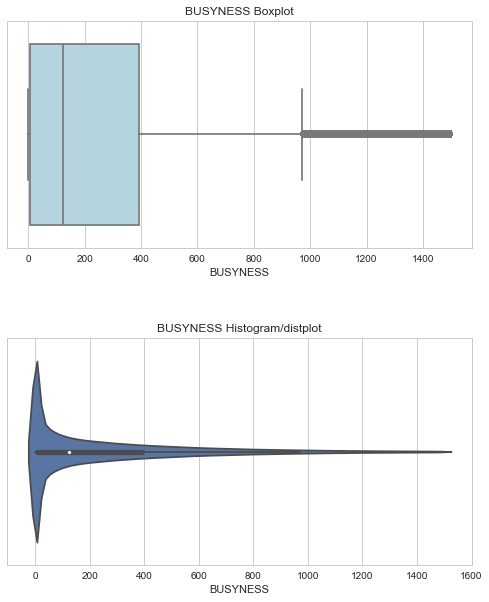

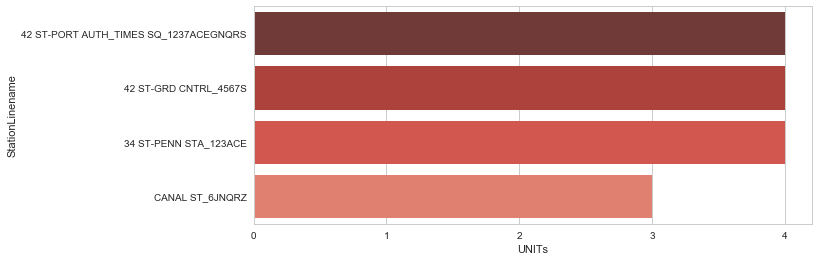

The STATIONs with the most UNITs on 2013-08-01 00:00:00 were:


,StationLinename,UNIT
0,42 ST-PORT AUTH_TIMES SQ_1237ACEGNQRS,4
1,42 ST-GRD CNTRL_4567S,4
2,34 ST-PENN STA_123ACE,4
3,CANAL ST_6JNQRZ,3


________________________________________________________________________

Computing data analysis problem 2:
What is the total number of entries & exits across the subway system for August 1, 2013?

Estimated Total Entries & EXITS across the subway system on 20130801:


,date,BUSYNESS
0,2013-08-01,"8,346,282"


________________________________________________________________________

Computing data analysis problem 3a:
What station was the busiest on August 1, 2013?

Estimated Busiest Station on 20130801:


,StationLinename,BUSYNESS
0,42 ST-PORT AUTH_TIMES SQ_1237ACEGNQRS,"284,124"
1,34 ST-PENN STA_123ACE,"255,258"
2,42 ST-GRD CNTRL_4567S,"157,087"
3,34 ST-HERALD SQ_BDFMNQR,"148,785"
4,14 ST-UNION SQ_456LNQR,"113,411"


------------------------------------------------------------------------

Computing data analysis problem 3b:
What turnstile was the busiest on that date?



,StationLinename,turnstile,BUSYNESS
0,14 ST-UNION SQ_456LNQR,R221 R170 01-03-02,"6,823"
1,34 ST-HERALD SQ_BDFMNQR,N506 R022 00-05-05,"6,421"
2,103 ST_6,R252 R180 00-00-04,"6,222"
3,LEXINGTON-53 ST_6EM,N306 R017 00-03-03,"6,096"
4,34 ST-HERALD SQ_BDFMNQR,N506 R022 00-00-00,"6,072"


________________________________________________________________________

Computing data analysis problem 4:
What stations have seen the most usage growth/decline in 2013?

Stations with most usage growth in 2013 (estimated):


,StationLinename,MA20_diff,MA20_MyPctChg
0,AQUEDUCT TRACK_A,"173,438.50","20,771.08"
1,KNICKERBOCKER_M,"270,955.55",0.40
3,DYCKMAN ST_1,"755,091.30",0.30
4,FT HAMILTON PKY_D,"386,504.75",0.25
5,COURT SQ_7EGM,"1,253,293.00",0.24
7,BAY PARKWAY_D,"775,845.55",0.22
8,EAST BROADWAY_F,"1,159,569.00",0.21
9,JFK JAMAICA CT1_E,"563,889.60",0.19
10,25 AVE_D,"293,695.60",0.19
11,71 ST_D,"341,521.40",0.19


Stations with most usage decline in 2013 (estimated):


,StationLinename,MA20_diff,MA20_MyPctChg
433,CENTRAL AVE_M,"-505,096.60",-0.51
432,BROAD CHANNEL_AS,"-43,247.40",-0.45
431,BEACH 98 ST_AS,"-156,381.95",-0.45
430,BEACH 105 ST_AS,"-68,376.25",-0.41
429,BEACH 90 ST_AS,"-218,061.15",-0.40
428,BEACH 44 ST_A,"-131,249.45",-0.40
427,ROCKAWAY PK 116_AS,"-194,301.80",-0.39
426,BEACH 67 ST_A,"-371,302.55",-0.33
425,BEACH 25 ST_A,"-270,378.60",-0.32
424,BEACH 36 ST_A,"-131,245.55",-0.31


________________________________________________________________________

Computing data analysis problem 5a:
What dates are the least busy?

Least Busy Dates in 2013:


,date,WeekDay,BUSYNESS
0,2013-12-25,Wed,"3,289,323"
1,2013-02-09,Sat,"4,022,753"
2,2013-11-28,Thu,"4,084,615"
3,2013-02-03,Sun,"4,209,732"
4,2013-01-27,Sun,"4,273,965"
5,2013-01-13,Sun,"4,322,351"
6,2013-02-24,Sun,"4,346,526"
7,2013-01-06,Sun,"4,347,607"
8,2013-03-10,Sun,"4,373,695"
9,2013-02-10,Sun,"4,393,363"


------------------------------------------------------------------------

Computing data analysis problem 5b:
Could you identify days on which stations were not operating at full capacity or closed entirely?

Stations Not Operating at Capacity or Possibly Closed in 2013:
Define StationLinename Undercapacity as Daily BUSYNESS < 0.5 of BUSYNESS 10 Day Moving Average
(Stations not at capacity sorted on top and possible closed stations sorted on bottom)

StationLinename BUSYNESS vs. BUSYNESS 10 Day Moving Average


,date,StationLinename,BUSYNESS,WeekDay,BUSYNESS_MA10
0,2013-11-16,MAIN ST_7,2826,Sat,"57,017"
1,2013-05-03,BARCLAYS CENTER_2345BDNQR,6026,Fri,"55,032"
2,2013-12-25,JAY ST-METROTEC_ACFR,10576,Wed,"54,212"
3,2013-04-14,MAIN ST_7,70,Sun,"51,071"
4,2013-12-25,BOROUGH HALL/CT_2345R,9921,Wed,"48,879"
5,2013-12-25,23 ST_6,7769,Wed,"46,996"
6,2013-11-17,MAIN ST_7,22,Sun,"45,178"
7,2013-01-25,77 ST_6,66,Fri,"42,844"
8,2013-01-22,77 ST_6,9800,Tue,"41,803"
9,2013-12-25,WALL ST_23,7048,Wed,"40,927"


In [0]:
# ### READ pickled files if needed

read_df12clean_pkl=0
if read_df12clean_pkl:
    df12clean = pickle.load(open('df12clean.pkl','rb'))
    print('pickle files read and assigned')
    
read_df13clean_pkl=0
if read_df13clean_pkl:
    df13clean = pickle.load(open('df13clean.pkl','rb'))
    print('pickle files read and assigned')
    
def main():
    # referring to the quantiles during creation of raw data, we'll just clip any BUSYNESS per turnstile audit > 1500  
    data12 = df12clean.loc[df12clean.BUSYNESS<=1500]
    data13 = df13clean.loc[df13clean.BUSYNESS<=1500]
    # exclude non-NYC stations
    nyc_divisions = ['BMT','IND','IRT']
    data12,data13 = data12.loc[data12.DIVISION.isin(nyc_divisions)],data13.loc[data13.DIVISION.isin(nyc_divisions)]
    # show data distribution
#     distplot(data12,features=['BUSYNESS'],describe=0)
    distplot(data13,features=['BUSYNESS'],describe=0)
    # data analysis problems:
    problem1(data13,date=pd.datetime(2013,8,1),maxrows=4)
    problem2(data13)  
    problem3(data13,iloc_size=5)
    problem4(data12,data13,regular=1,ratiolow=.25,ratiolimit=5,method='mean',ma=20,diffmax=3000000,return_ma=True,rows=10)
    problem5(data13,iloc_size_a=10,ma=10,low_thresh=100,qtile=0.5,printdf=1,plot=0,returndf=0)
if __name__=='__main__':
    main()

### Response to Visualization Problems

       BUSYNESS
count 2,631,793
mean        256
std         313
min           0
25%           9
50%         131
75%         392
max       1,500
Computing vizualization problem 1:
Plot the daily row counts for data files in Q3 2013



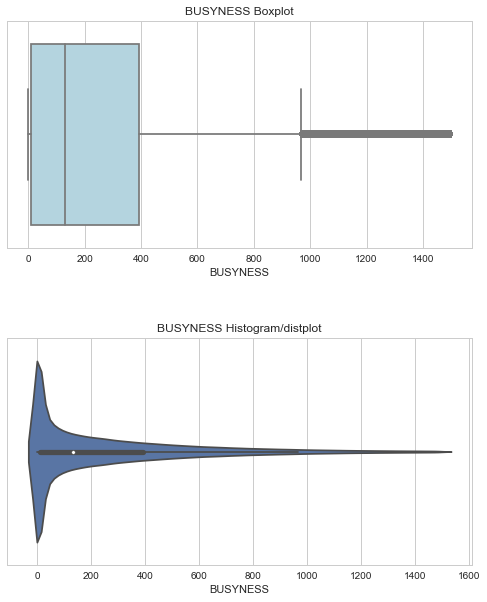

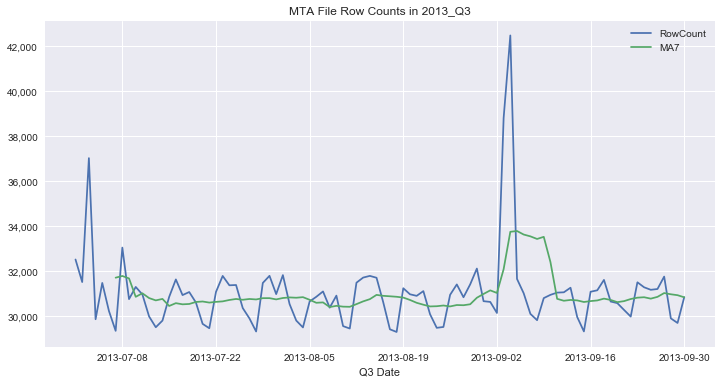

In [0]:
try:
    df_q313
    df13clean
except:
    NameError
    df_q313 = pickle.load(open('df_q313.pkl','rb'))
    df13clean = pickle.load(open('df13clean.pkl','rb'))
    nyc_divisions = ['BMT','IND','IRT']
    dfclean13q3 = df13clean[(df13clean['date']>=pd.datetime(2013,7,1))
                          &(df13clean['date']<pd.datetime(2013,10,1))
                          &(df13clean['BUSYNESS']<=1500)
                          &(df13clean.DIVISION.isin(nyc_divisions)) 
                         ]
    print('pickle files read and assigned')

distplot(dfclean13q3,features=['BUSYNESS'],describe=1)

viz_problem1(df_q313,ma=7)

Computing vizualization problem 2:
Plot the daily total number of entries & exits across the system for Q3 2013



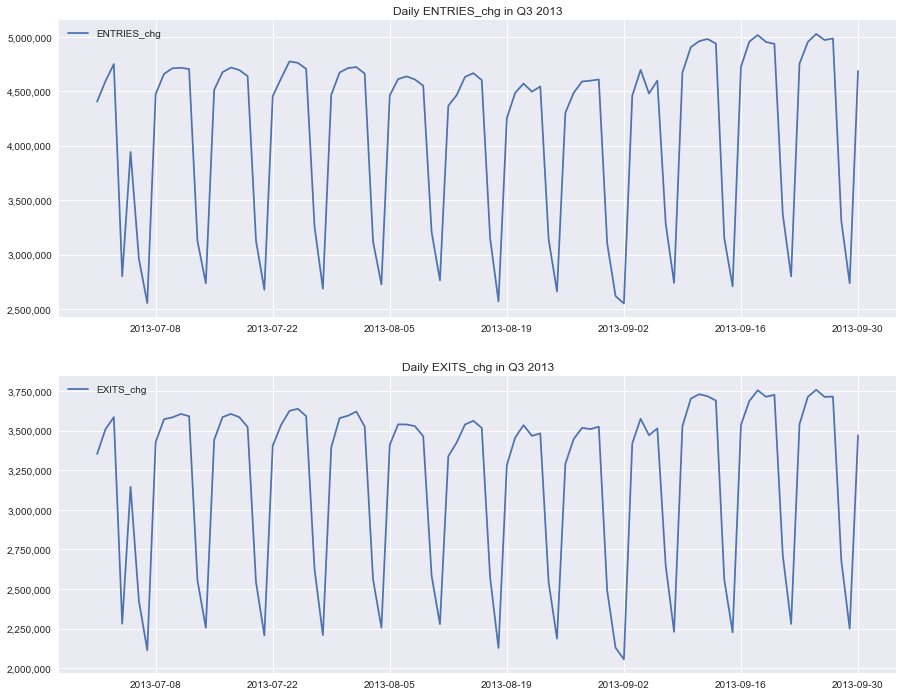

In [0]:
viz_problem2(dfclean13q3)

Computing vizualization problem 3:
Plot the mean and standard deviation of the daily total number of entries & exits for each month in Q3 2013 for station 34 ST-PENN STA.



,Month,mean,std
0,7,"225,386","42,345"
1,8,"222,887","43,972"
2,9,"217,676","45,943"


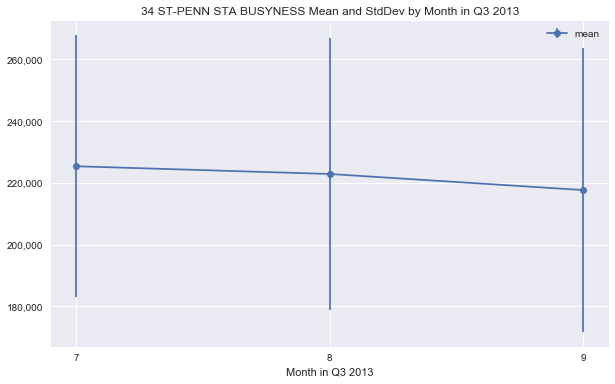

In [0]:
viz_problem3(dfclean13q3,station='34 ST-PENN STA')

Computing vizualization problem 4:
Plot 25/50/75 percentile of the daily total number of entries & exits for each month in Q3 2013 for station 34 ST-PENN STA.

Lower/upper edge of boxplot equals 25%ile/75%ile and line in box is the median (50%ile):



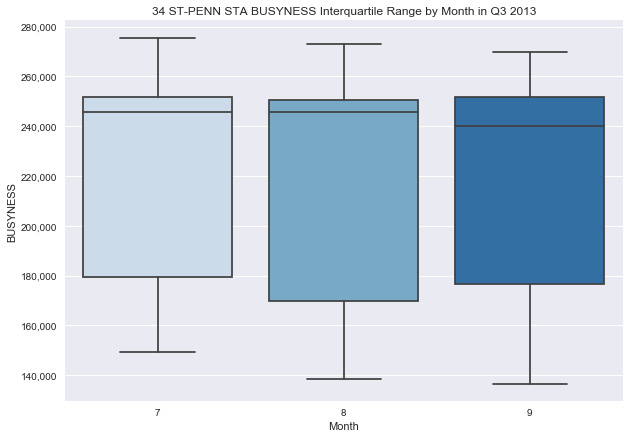

In [0]:
viz_problem4(dfclean13q3,station='34 ST-PENN STA')

Computing vizualization problem 5:
Plot the daily number of closed stations and number of stations that were not operating at full capacity in Q3 2013

Defining Undercapacity by StationLinename as BUSYNESS < BUSYNESS_MA10.quantile(0.5)

Computing data analysis problem 5b:
Could you identify days on which stations were not operating at full capacity or closed entirely?

Stations Not Operating at Capacity or Possibly Closed in 2013:
Define StationLinename Undercapacity as Daily BUSYNESS < 0.5 of BUSYNESS 10 Day Moving Average
(Stations not at capacity sorted on top and possible closed stations sorted on bottom)


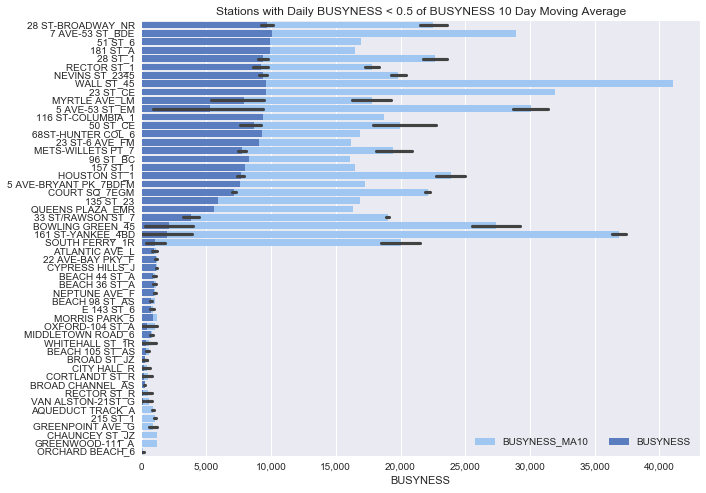

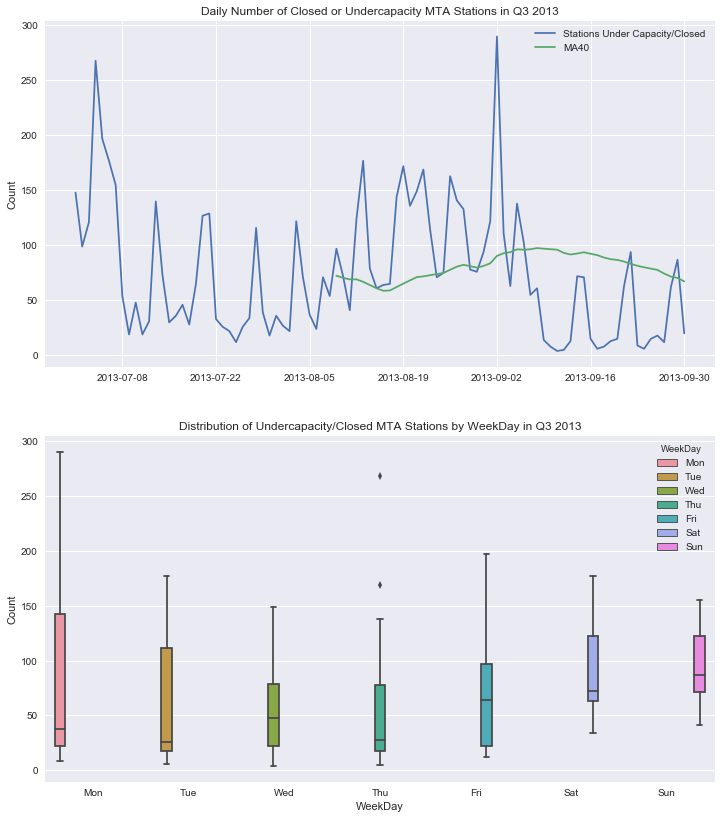

In [0]:
viz_problem5(dfclean13q3,qtile=0.5,ma=10)